<a href="https://colab.research.google.com/github/aliammar0161/Mpro-inhibitor-discovery/blob/main/ML_for_Mpro_inhibitor_discovery_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations


In [ ]:
!pip install mols2grid
!pip install pubchempy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13818 sha256=a6b8dff1b8cc2fab06bd64bcb80cb76658aba4363972ecf95e810fded7f5297f
  Stored in directory: /root/.cache/pip/wheels/8b/e3/6c/3385b2db08b0985a87f5b117f98d0cb61a3ae3ca3bcbbd8307
Successfully built pubchempy


In [ ]:
!pip install shap

In [ ]:
!pip install umap-learn
!pip install optuna
!pip install deepchem


!pip install matplotlib
!pip install -U scikit-learn
!pip install flaml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 46.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 10.3 MB/s eta 0:00:00


# Imports

In [ ]:
import mols2grid

from pubchempy import get_compounds, Compound

In [ ]:
from tqdm import tqdm
import shap
from IPython.core.display import HTML

In [ ]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score
import umap
import seaborn as sns

import matplotlib.pyplot as plt

In [ ]:
# Import RDkit

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw # to draw molecules
from rdkit.Chem.Draw import IPythonConsole # to draw inline in iPython
from rdkit.Chem import AllChem  # we need this to compute 2D depictions
from rdkit.Chem import rdDepictor  # to generate 2D depictions of molecules
from rdkit.Chem.Draw import rdMolDraw2D # to draw 2D molecules using vectors
from rdkit.Chem import PandasTools # we use this to read in SDFs into pandas dataframes
from rdkit import DataStructs # to compare molecular simularity

# What version of RDKit are we running?
print(rdkit.__version__)

2025.03.3


In [ ]:
from copy import deepcopy  # we need deep copies of the molecule to avoid losing 3D coordinates
import pandas as pd # we need this to make copies of pandas columns of molecules
from IPython.display import SVG # to use Scalar Vector Graphics (SVG) not bitmaps, for cleaner lines
import numpy as np
# Import molecular graphics packages

# For visualising on colab
from google.colab import output
output.enable_custom_widget_manager()
from ipywidgets import interactive, VBox
from IPython.core.display import Image

In [ ]:
import math
#from flaml import AutoML

In [ ]:
import deepchem as dc
dc.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.0'

In [ ]:
import optuna

import xgboost as xgb

# Functions

##Metric calculation

In [1]:
def model_metrics_calc (y_true, y_pred, y_prob_pred):
  # Compute accuracy
  accuracy = accuracy_score(y_true, y_pred)
  print(f"Test accuracy: {accuracy * 100:.2f}%")

  # Compute score
  f1 = f1_score(y_true, y_pred)
  print(f"F1 score: {f1}")

  # Compute matthew correlation coefficient
  mcc = matthews_corrcoef(y_true, y_pred)
  print(f"Matthew Correlation Coefficient: {mcc}")

  # Compute area under curve
  aucroc = roc_auc_score(y_true, y_prob_pred)
  print(f"Aucroc: {aucroc}")

  # Compute Precision
  precision = precision_score(y_true, y_pred)
  print(f"Precision: {precision}")

  # Compute Recall
  recall = recall_score(y_true, y_pred)
  print(f"Recall: {recall}")

  cm = confusion_matrix(y_true, y_pred)

  # Visualize it with Matplotlib
  plt.figure(figsize=(3,2))
  sns.heatmap(cm, annot=True, fmt='d', cmap="Reds", )#annot_kws={"size": 8}
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.show()

  fpr, tpr, thresholds = roc_curve(y_true, y_prob_pred)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # this is for the random (chance) prediction
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

  return f1

##RDKit Functions

In [ ]:
def set_atom_index_labels(mol, label, one_based=False):
  """Draws the molecule and labels the atoms with their index.

See https://stackoverflow.com/questions/53321453/rdkit-how-to-show-moleculars-atoms-number?answertab=active#tab-top

'mol':
    an RDKit molecule.
'label':
    'atomLabel' changes each element name to its numeric index.
    'molAtomMapNumber' labels each atom with a colon followed by the index.
    'atomNote' puts the index next to the element name.
'one_based', optional:
    False by default, so atoms will be indexed from zero.

  """
  for atom in mol.GetAtoms():
    if one_based:
      str_index = str(atom.GetIdx()+1)
      print(atom)
    else:
      str_index = str(atom.GetIdx())
    atom.SetProp(label, str_index)
  return mol

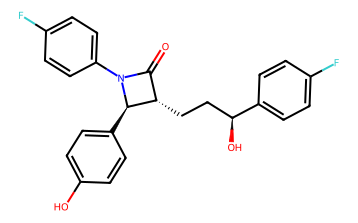

In [ ]:
def mol_to_image(molecule, scaling=20, font_size=24):
  """Draw a molecule with the supplied RDKit molecule object,
  and allow control of scaling and font size.
  The units of scaling are ~pixels/Angstrom"""
  d2d = Draw.MolDraw2DCairo(-1,-1)
  d2d.drawOptions().scalingFactor = scaling  # units are roughly pixels/angstrom
  d2d.drawOptions().fixedFontSize = font_size
  d2d.DrawMolecule(molecule)
  d2d.FinishDrawing()
  Image(d2d.GetDrawingText())
  return Image(d2d.GetDrawingText())

def smiles_to_image(molecule_SMILES, scaling=20, font_size=24):
  """Draw a molecule with the supplied SMILES string,
  and allow control of scaling and font size.
  The units of scaling are ~pixels/Angstrom"""
  image = mol_to_image(Chem.MolFromSmiles(molecule_SMILES),
                       scaling=scaling, font_size=font_size)
  return image

ezetimibe_SMILES = 'O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O)cc2)N1c1ccc(F)cc1'
smiles_to_image(ezetimibe_SMILES, font_size=10)

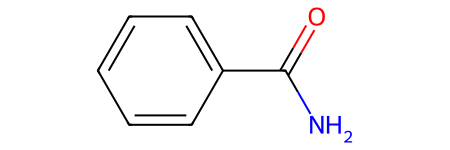

In [ ]:
def draw_mol_with_SVG(mol, molSize=(450,150)):
  """Use SVG to draw an RDKit molecule, mol."""
  mc = Chem.Mol(mol.ToBinary())
  if not mc.GetNumConformers():
    # Compute 2D coordinates
    rdDepictor.Compute2DCoords(mc)

  # Initialize the drawer with the size
  drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])

  # Draw the molcule
  drawer.DrawMolecule(mc)
  drawer.FinishDrawing()

  # Get the SVG string
  svg = drawer.GetDrawingText()

  # Fix the SVG string and display it
  display(SVG(svg.replace('svg:','')))

mol = Chem.MolFromSmiles('c1ccccc1C(=O)N')
draw_mol_with_SVG(mol)

In [ ]:
def draw_mol_highlighted(mol, substructure, size=(400, 200)):
    """Based on code from betelgeuse on Stack Overflow;
    See: https://stackoverflow.com/questions/69735586/how-to-highlight-the-substructure-of-a-molecule-with-thick-red-lines-in-rdkit-as"""
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])

    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    return svg.replace('svg:','')

In [ ]:
def get_IUPAC_name_from_smiles(smiles):
  """Use PubChemPy's get_compounds to look up the IUPAC name from the molecule
  supplied as a SMILES string."""
  cpds = get_compounds(smiles, 'smiles')
  assert len(cpds) == 1 # Hopefully, there is only one IUPAC name
  c = cpds[0]
  return c.iupac_name

def get_synonyms_from_smiles(smiles):
  """Use PubChemPy's get_compounds to look up the synomyms from the molecule
  supplied as a SMILES string."""
  cpds = get_compounds(smiles, 'smiles')
  assert len(cpds) == 1 # Hopefully, there is only one IUPAC name
  c = cpds[0]
  return c.synonyms

In [ ]:
def standardize_mol(mol, verbose=False):
    """Standardize the RDKit molecule, select its parent molecule, uncharge it,
    then enumerate all the tautomers.
    If verbose is true, an explanation of the steps and structures of the molecule
    as it is standardized will be output."""
    # Follows the steps from
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg Landrum) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ -- JP

    from rdkit.Chem.MolStandardize import rdMolStandardize
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)
    if verbose:
      print('Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:')
      draw_mol_with_SVG(clean_mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    if verbose:
      print('Select the "parent" fragment:')
      draw_mol_with_SVG(parent_clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    if verbose:
      print('Neutralize the molecule:')
      draw_mol_with_SVG(uncharged_parent_clean_mol)

    # Note: no attempt is made at reionization at this step
    # nor ionization at some pH (RDKit has no pKa caculator);
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogues, etc.
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    if verbose:
      print('Enumerate tautomers:')
      draw_mol_with_SVG(taut_uncharged_parent_clean_mol)
    assert taut_uncharged_parent_clean_mol != None

    if verbose: print(Chem.MolToSmiles(taut_uncharged_parent_clean_mol))
    return taut_uncharged_parent_clean_mol

def standardize_smiles(smiles, verbose=False):
  """Standardize the SMILES string, select its parent molecule, uncharge it,
    then enumerate all the tautomers."""
  if verbose: print(smiles)
  std_mol = standardize_mol(Chem.MolFromSmiles(smiles), verbose=verbose)
  return Chem.MolToSmiles(std_mol)

# Import COVID Moonshot Data


In [ ]:
!wget https://covid.postera.ai/covid/activity_data.csv
%ls

data = pd.read_csv("activity_data.csv")

--2025-06-23 18:05:21--  https://covid.postera.ai/covid/activity_data.csv
Resolving covid.postera.ai (covid.postera.ai)... 44.245.50.241, 54.186.242.126
Connecting to covid.postera.ai (covid.postera.ai)|44.245.50.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 295882 (289K) [text/csv]
Saving to: ‘activity_data.csv’

activity_data.csv   100%[===================>] 288.95K   513KB/s    in 0.6s    

2025-06-23 18:05:23 (513 KB/s) - ‘activity_data.csv’ saved [295882/295882]

activity_data.csv  sample_data/


In [ ]:
# Clean the data so that only chemicals with f_IC50 values remain
data_f = data[["SMILES","f_avg_IC50"]].dropna()

# Clean data so that chemicals with r_IC50 value remain

data_r = data[["SMILES","r_avg_IC50"]].dropna()


shows that standardisation isnt necessary when run

In [ ]:
data_f_IC50 = data_f["f_avg_IC50"].astype(float)

data_f_pIC50 = np.log10(data_f_IC50/1000000)*-1


In [ ]:
data_f_labels = np.where(data_f_pIC50 <= 6, 0, 1) # 1 = high affinity, 0 = low affinity
print(data_f_labels)

[1 1 0 ... 0 0 0]


#Featuriser

In [ ]:
# Initialise Featuriser
featuriser = dc.feat.MACCSKeysFingerprint()
featuriser = dc.feat.CircularFingerprint(radius=3)

In [ ]:

data_f_features = featuriser(data_f["SMILES"])

In [ ]:
print(data_f)

                                                 SMILES  f_avg_IC50
0     CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...    0.275118
1     O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...    0.202767
2     CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...   55.453947
3     CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...    0.050000
4     CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...    0.052757
...                                                 ...         ...
2057                   N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1   99.010000
2058                    N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1   54.272964
2059               N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1   63.554925
2060                 N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1   26.719515
2061                      O=C(Cc1cncc2ccccc12)Nc1ccccc1   57.590417

[1926 rows x 2 columns]


In [ ]:
print(len(data_f_features[0]))


2048


#Similarity Search

In [ ]:
fpgen = AllChem.GetMorganGenerator(radius=2)
fps = [fpgen.GetSparseCountFingerprint(Chem.MolFromSmiles(x)) for x in data_f["SMILES"]]

In [ ]:
#Nirmatralvir
search = fpgen.GetSparseCountFingerprint(Chem.MolFromSmiles("N#C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]1N(C[C@H]2[C@@H]1C2(C)C)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F"))


#379 (highest pIC50)
#search = fpgen.GetSparseCountFingerprint(Chem.MolFromSmiles("CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@@H]([C@H]1C(=O)N[C@H](C#N)C[C@@H]1CCNC1=O)C2(C)C"))


#search = fpgen.GetSparseCountFingerprint(Chem.MolFromSmiles("c1ccc2c(c1)cncc2NC(=O)Cc3cccc(c3)Cl"))
tanimoto_similarities = [DataStructs.TanimotoSimilarity(search,x) for x in fps]

In [ ]:
max(tanimoto_similarities)

1.0

In [ ]:
len(tanimoto_similarities)

1926

In [ ]:
for ind, x in enumerate(tanimoto_similarities):
  if x>0.999:
    print(ind)

379


#umap from blopig


In [ ]:
#Define methods for fingerprints
#Computed using 2048 bits with radius 2

#Convert list of SMILES to list of fingerprints
def fingerprint_list_from_smiles_list(smiles_list, n_bits=2048):
    fingerprint_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fingerprint_list.append(fingerprint_as_array(mol, n_bits))
    return fingerprint_list

def fingerprint_as_array(mol, n_bits=2048):
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    array = np.zeros((1,), int)
    DataStructs.ConvertToNumpyArray(fingerprint, array)
    return array

In [ ]:
fingerprint_SARS_CoV_2_smiles_filter = fingerprint_list_from_smiles_list(data_f["SMILES"])

print(fingerprint_SARS_CoV_2_smiles_filter)

In [ ]:
fingerprint_array_SARS_CoV_2_smiles_filter = np.array(fingerprint_SARS_CoV_2_smiles_filter)


In [ ]:
#Compute UMAP on the SARS_CoV_2 database
umaper = umap.UMAP()

In [ ]:
umap_fingerprint_array_SARS_CoV_2_smiles_filter = umaper.fit_transform(data_f_features)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
#Place the UMAP result into a pandas dataframe for plotting
umap_fingerprint_array_SARS_CoV_2_smiles_filter_fig = pd.DataFrame(umap_fingerprint_array_SARS_CoV_2_smiles_filter,columns=["X","Y"])


In [ ]:
#Set the figure for seaborn
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

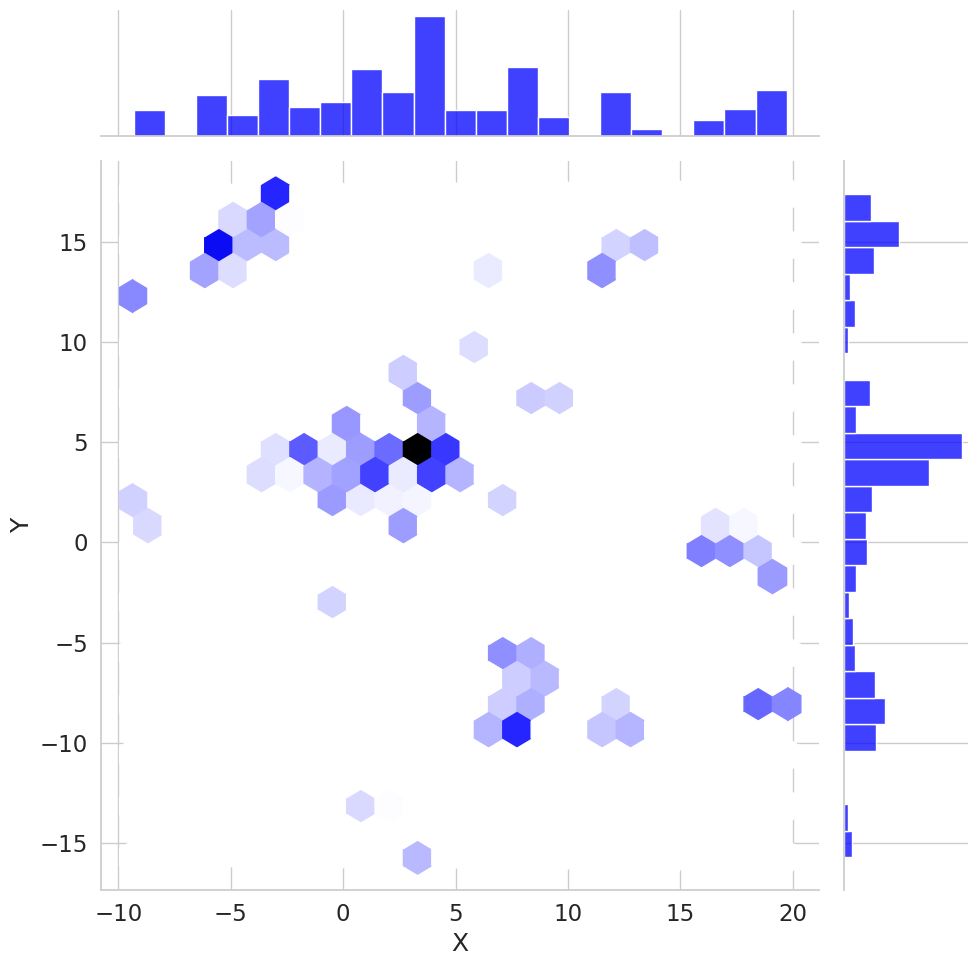

In [ ]:
#Visualize the UMAP using seaborn
fig = sns.jointplot(data=umap_fingerprint_array_SARS_CoV_2_smiles_filter_fig,x="X",y="Y", kind="hex", height=10, ratio=5, color="blue")


# Classification Data split


## Set Data to become deepchem dataset


In [ ]:
np.sum(data_f_labels) # Number of high potency values

np.int64(466)

In [ ]:
# Using scaffold because model will be more likely to recieve training information based on a variety of chemical structures, compared to random splitting
# (Could experiment with random splitting too? and include finding in report)


dataset_f_classif = dc.data.DiskDataset.from_numpy(X=data_f_features,y=data_f_labels,ids=data_f["SMILES"])

print(dataset_f_classif)



<DiskDataset X.shape: (np.int64(1926), np.int64(2048)), y.shape: (np.int64(1926),), w.shape: (np.int64(1926),), task_names: [0]>


## Scaffold splitter

In [ ]:
splitter = dc.splits.ScaffoldSplitter()
train_dataset_f_c, valid_dataset_f_c, test_dataset_f_c = splitter.train_valid_test_split(dataset_f_classif,
                                                                            frac_train = 0.75,
                                                                            frac_valid = 0,
                                                                            frac_test  = 0.25 )

In [ ]:
print(test_dataset_f_c.y)

print("\nNumber of high values in test:")
print(np.sum(test_dataset_f_c.y))

print("\nNumber of high values in train")
print(np.sum(train_dataset_f_c.y))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 1]

Number of high value

#Confirm good split using umap


In [ ]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(dataset_f_classif.X)
embedding.shape

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(1926, 2)

##Spread of high and low affinity


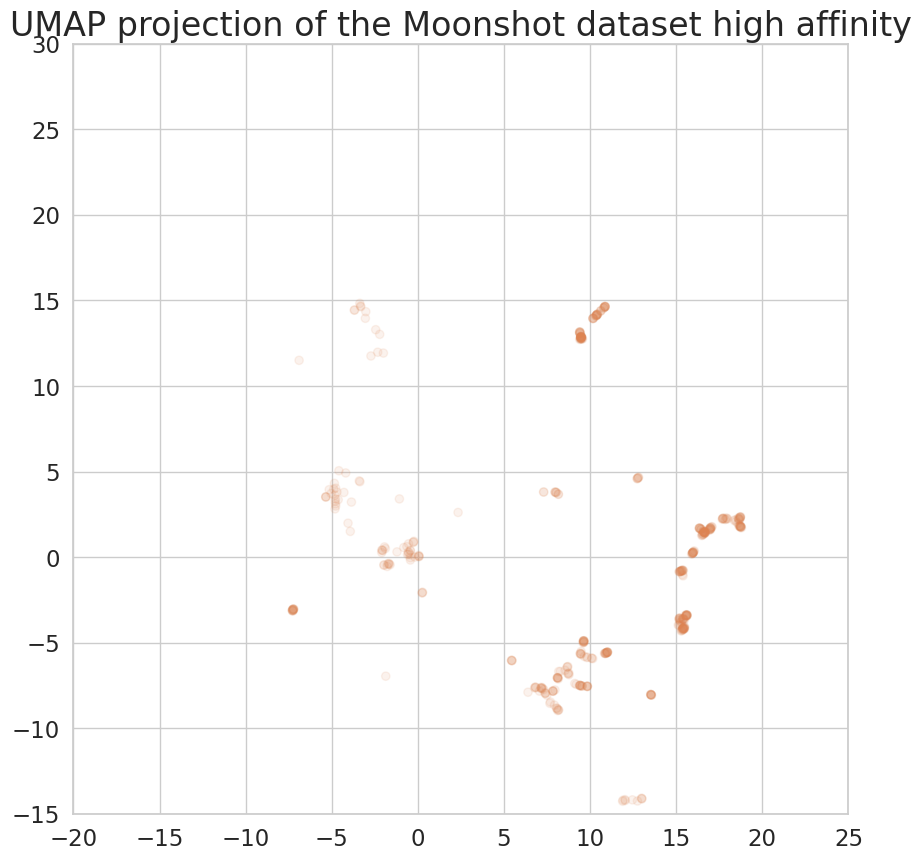

In [ ]:
high_val_embed= np.array([embedding[i] for i,x in enumerate(dataset_f_classif.y) if x==1])

plt.scatter(
    high_val_embed[:, 0],
    high_val_embed[:, 1],
    c=[sns.color_palette()[x] for x in dataset_f_classif.y if x==1 ],
    alpha = 0.1)


plt.xlim(-20,25)
plt.ylim(-15,30)
plt.title('UMAP projection of the Moonshot dataset high affinity', fontsize=24);

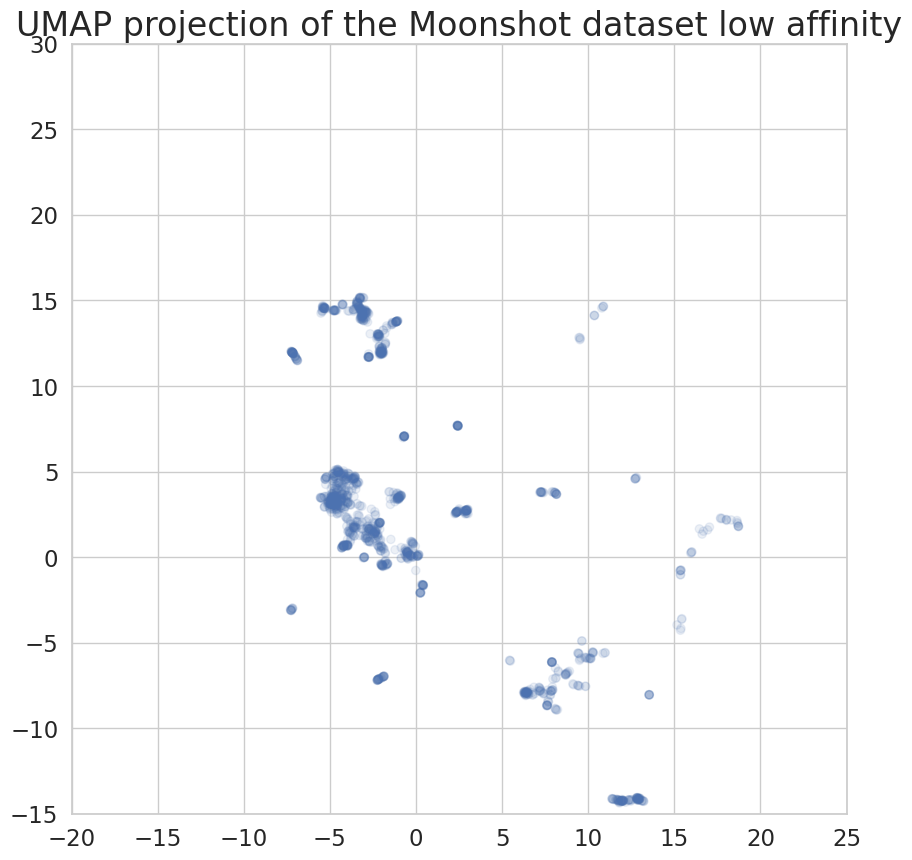

In [ ]:
low_val_embed= np.array([embedding[i] for i,x in enumerate(dataset_f_classif.y) if x==0])

plt.scatter(
    low_val_embed[:, 0],
    low_val_embed[:, 1],
    c=[sns.color_palette()[x] for x in dataset_f_classif.y if x==0 ],
    alpha = 0.1)

plt.xlim(-20,25)
plt.ylim(-15,30)
plt.title('UMAP projection of the Moonshot dataset low affinity', fontsize=24);

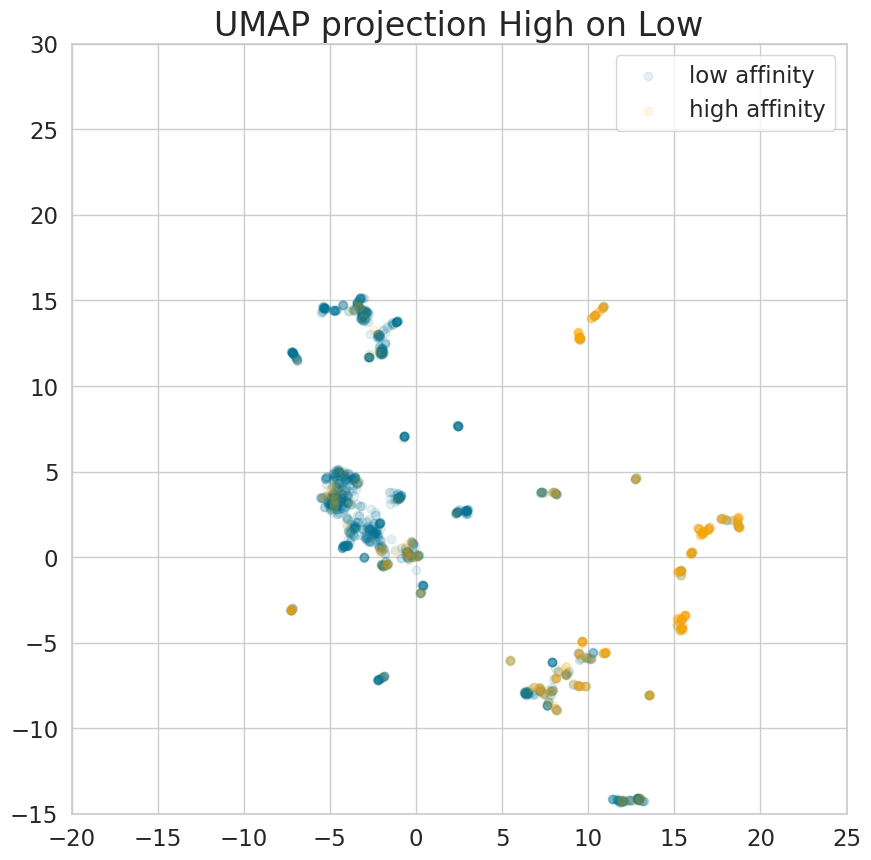

In [ ]:

plt.scatter(low_val_embed[:,0], low_val_embed[:,1], color='xkcd:sea blue', label='low affinity', alpha = 0.1)
plt.scatter(high_val_embed[:,0], high_val_embed[:,1], color='orange', label='high affinity', alpha = 0.1)
# Add a legend
plt.legend()

plt.xlim(-20,25)
plt.ylim(-15,30)
plt.title('UMAP projection High on Low', fontsize=24)
# Show the plot
plt.show()

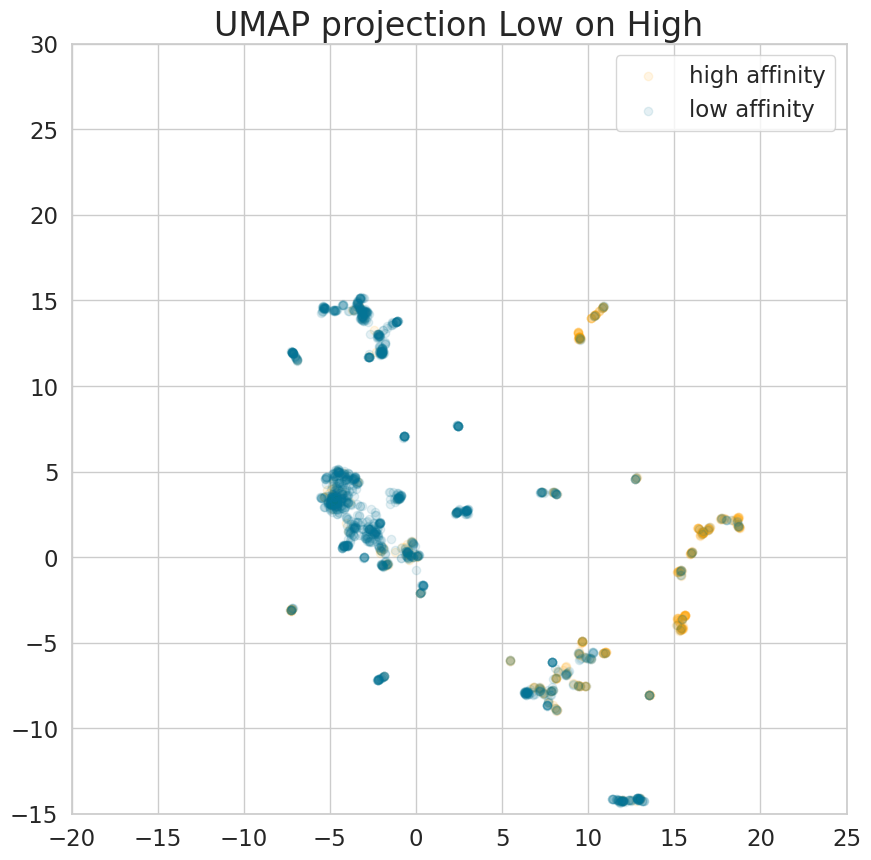

In [ ]:
plt.scatter(high_val_embed[:,0], high_val_embed[:,1], color='orange', label='high affinity', alpha = 0.1)
plt.scatter(low_val_embed[:,0], low_val_embed[:,1], color='xkcd:sea blue', label='low affinity', alpha = 0.1)

# Add a legend
plt.legend()


plt.xlim(-20,25)
plt.ylim(-15,30)

plt.title('UMAP projection Low on High', fontsize=24)
# Show the plot
plt.show()

##How does splitting spread the data?


In [ ]:


test_embed= np.array([embedding[i]  for i,x in enumerate(dataset_f_classif.ids) if x in test_dataset_f_c.ids])


train_embed= np.array([embedding[i]  for i,x in enumerate(dataset_f_classif.ids) if x in train_dataset_f_c.ids])
train_embed.shape



(1540, 2)

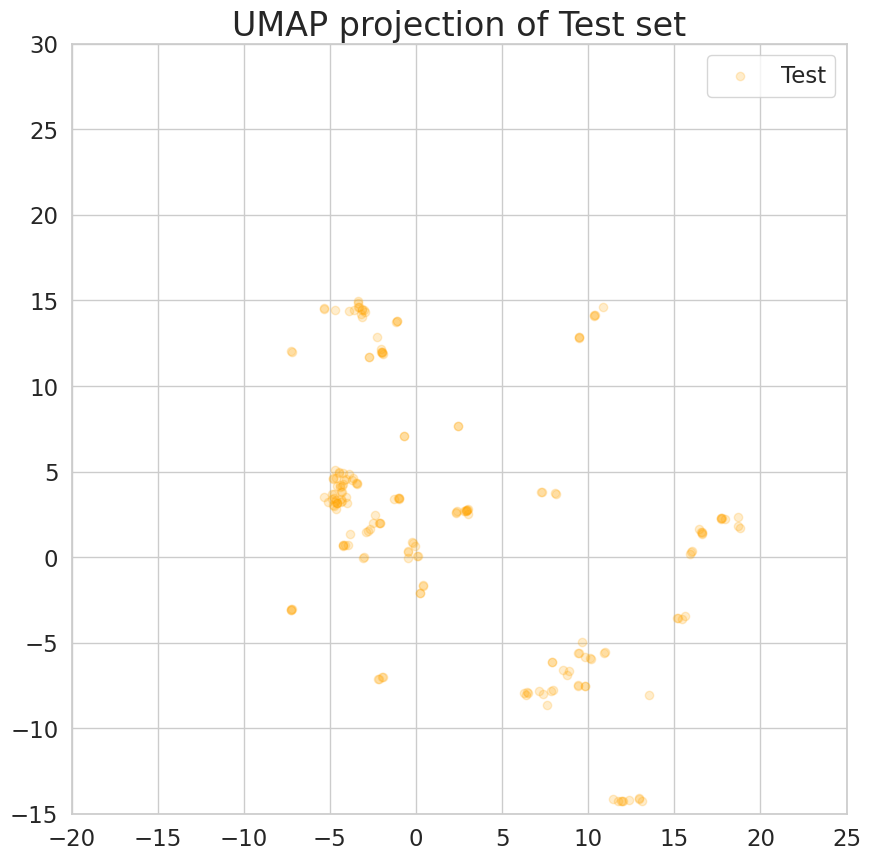

In [ ]:

plt.scatter(test_embed[:,0], test_embed[:,1], color='orange', label='Test', alpha = 0.2)
# Add a legend
plt.legend()


plt.xlim(-20,25)
plt.ylim(-15,30)
plt.title('UMAP projection of Test set', fontsize=24)
# Show the plot
plt.show()

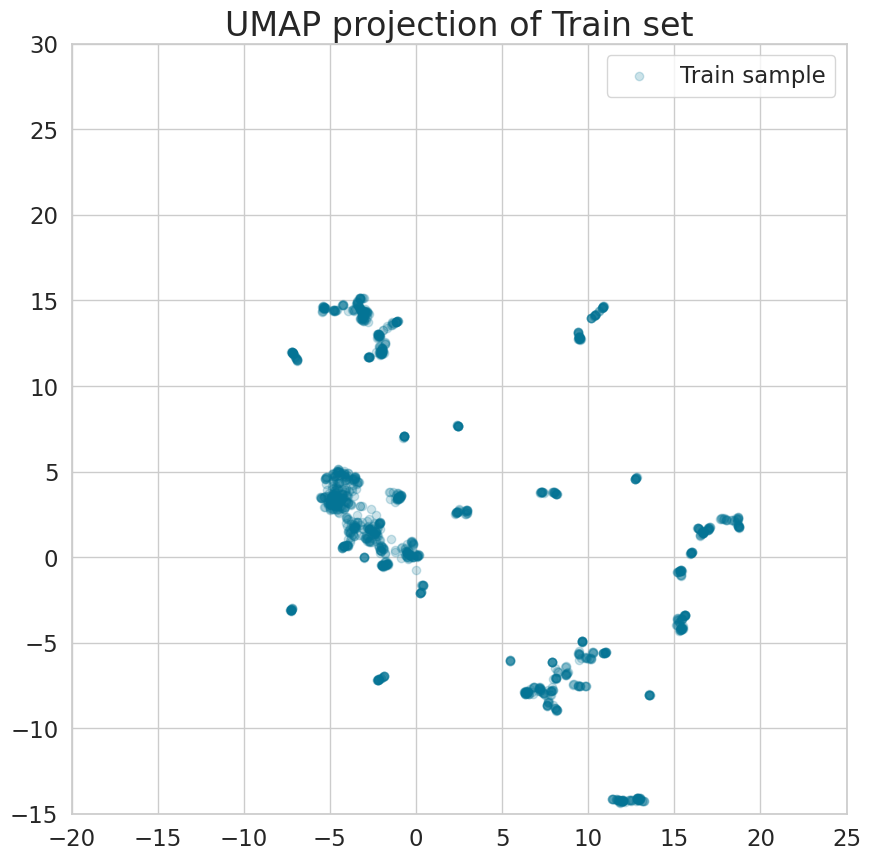

In [ ]:

plt.scatter(train_embed[:,0], train_embed[:,1], color='xkcd:sea blue', label='Train sample', alpha = 0.2)

# Add a legend
plt.legend()

plt.xlim(-20,25)
plt.ylim(-15,30)

plt.title('UMAP projection of Train set', fontsize=24)
# Show the plot
plt.show()

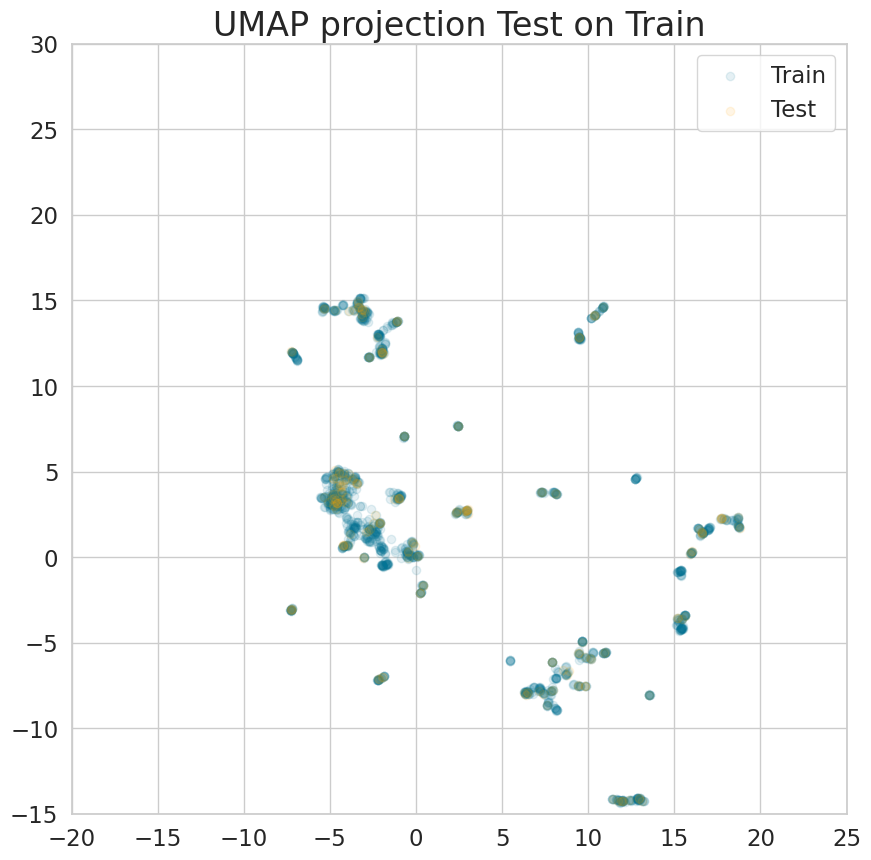

In [ ]:

plt.scatter(train_embed[:,0], train_embed[:,1], color='xkcd:sea blue', label='Train', alpha = 0.1)
plt.scatter(test_embed[:,0], test_embed[:,1], color='orange', label='Test', alpha = 0.1)
# Add a legend
plt.legend()
plt.xlim(-20,25)
plt.ylim(-15,30)
plt.title('UMAP projection Test on Train', fontsize=24)
# Show the plot
plt.show()

# perhaps the reason that machine learning works so well with scaffold split it because it is easier to predict the affinity of chemical in the dense orange section
# that over laps with the training set. there seems to be very few values in other spots.

#XGBoost

## Actual model/ prediction from optuna





[0]	train-logloss:0.53147	valid-logloss:0.47739
[1]	train-logloss:0.50442	valid-logloss:0.45803
[2]	train-logloss:0.48060	valid-logloss:0.44118
[3]	train-logloss:0.45957	valid-logloss:0.42754
[4]	train-logloss:0.44072	valid-logloss:0.41377
[5]	train-logloss:0.42442	valid-logloss:0.40273
[6]	train-logloss:0.40904	valid-logloss:0.39166
[7]	train-logloss:0.39541	valid-logloss:0.38268
[8]	train-logloss:0.38258	valid-logloss:0.37458
[9]	train-logloss:0.37131	valid-logloss:0.36646
[10]	train-logloss:0.36007	valid-logloss:0.36165
[11]	train-logloss:0.34988	valid-logloss:0.35484
[12]	train-logloss:0.34108	valid-logloss:0.34818
[13]	train-logloss:0.33195	valid-logloss:0.34362
[14]	train-logloss:0.32382	valid-logloss:0.33883
[15]	train-logloss:0.31667	valid-logloss:0.33562
[16]	train-logloss:0.30984	valid-logloss:0.33073
[17]	train-logloss:0.30360	valid-logloss:0.32583
[18]	train-logloss:0.29757	valid-logloss:0.32281
[19]	train-logloss:0.29196	valid-logloss:0.31957
[20]	train-logloss:0.28704	val

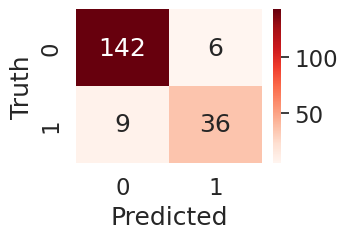

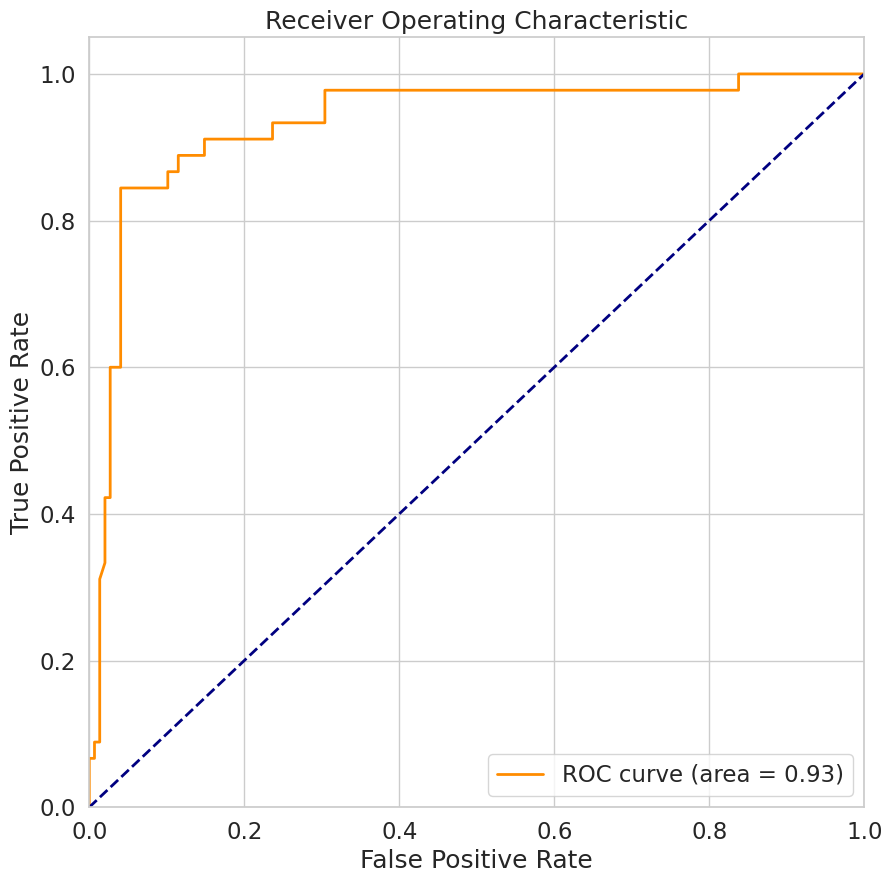

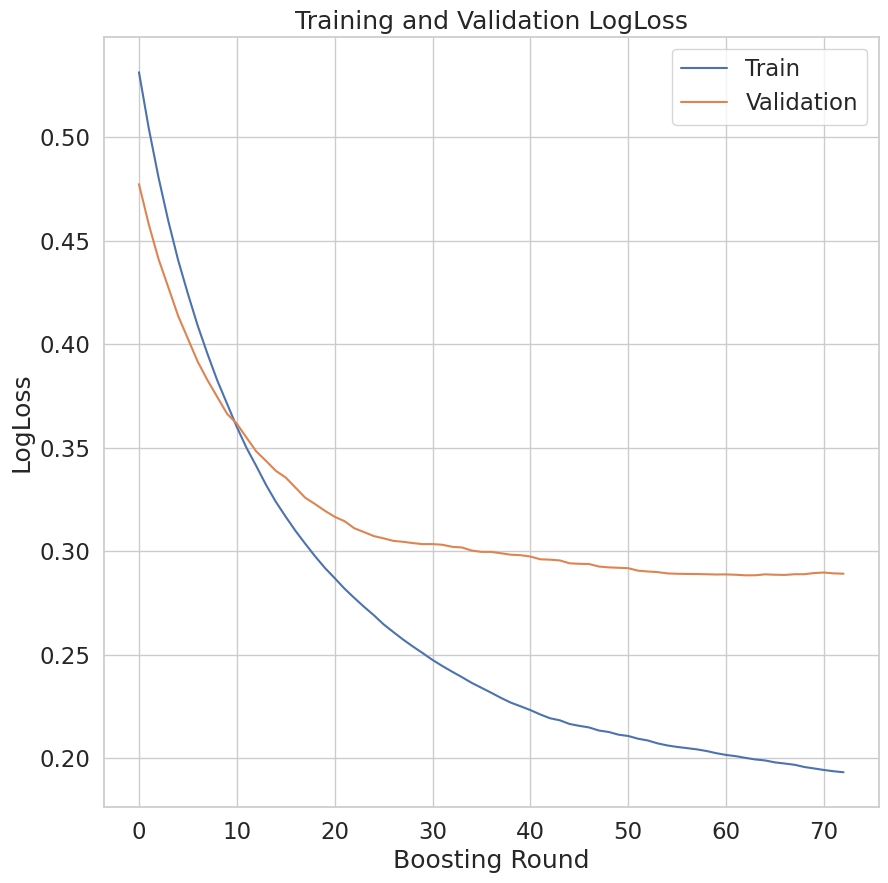

In [ ]:


# create a DMatrix
dtrain = xgb.DMatrix(train_dataset_f_c.X, label=train_dataset_f_c.y)
dtest = xgb.DMatrix(test_dataset_f_c.X, label= test_dataset_f_c.y)
dvalid = xgb.DMatrix(valid_dataset_f_c.X, label=valid_dataset_f_c.y)

# specify parameters
# parameters from optuna
param = {'objective': 'binary:logistic','booster': 'gbtree','lambda': 0.5502017520453772, 'alpha': 3.2707646459879734e-08, 'max_depth': 6, 'eta': 0.06482073900494274, 'gamma': 0.0006467974928444216, 'grow_policy': 'lossguide'}



# train the model

evals = [(dtrain, 'train'), (dvalid, 'valid')]
num_round = 200
evals_result = {}

#num_round = 10
model = xgb.train(param, dtrain, num_round, evals=evals, evals_result=evals_result, early_stopping_rounds=10)


# make prediction

predictions = model.predict(dtest)



bin_predictions = np.where(predictions <= 0.5, 0, 1)
#print(bin_predictions+test_dataset_f_c.y+predictions)

model_metrics_calc(test_dataset_f_c.y, bin_predictions, predictions)

train_rmse = evals_result['train']['logloss']
valid_rmse = evals_result['valid']['logloss']
plt.plot(train_rmse, label='Train')
plt.plot(valid_rmse, label='Validation')
plt.xlabel('Boosting Round')
plt.ylabel('LogLoss')
plt.title('Training and Validation LogLoss')
plt.legend()
plt.show()


## Cross Validation


0.5 threshold 

Test accuracy: 87.56%
F1 score: 0.7209302325581395
Matthew Correlation Coefficient: 0.6409302325581395
Aucroc: 0.8965891472868217
Precision: 0.7209302325581395
Recall: 0.7209302325581395


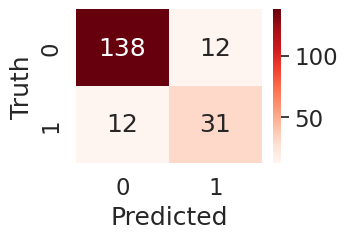

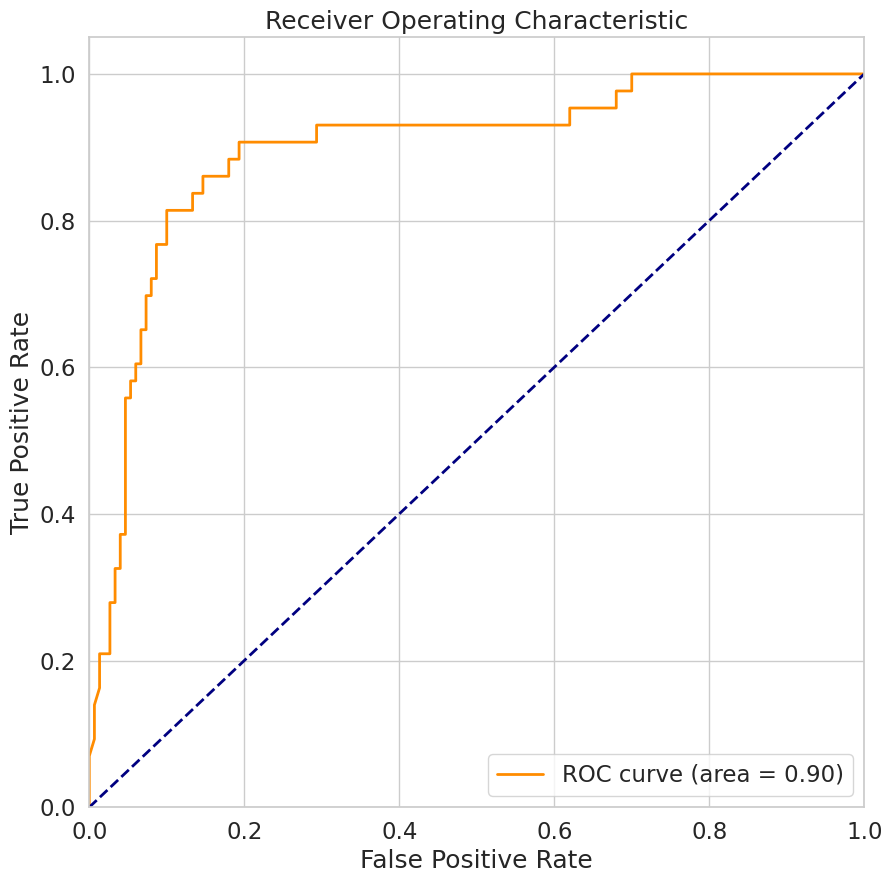

0.4 threshold 

Test accuracy: 87.56%
F1 score: 0.7446808510638298
Matthew Correlation Coefficient: 0.6674921512436325
Aucroc: 0.8965891472868217
Precision: 0.6862745098039216
Recall: 0.813953488372093


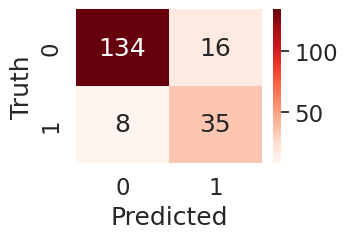

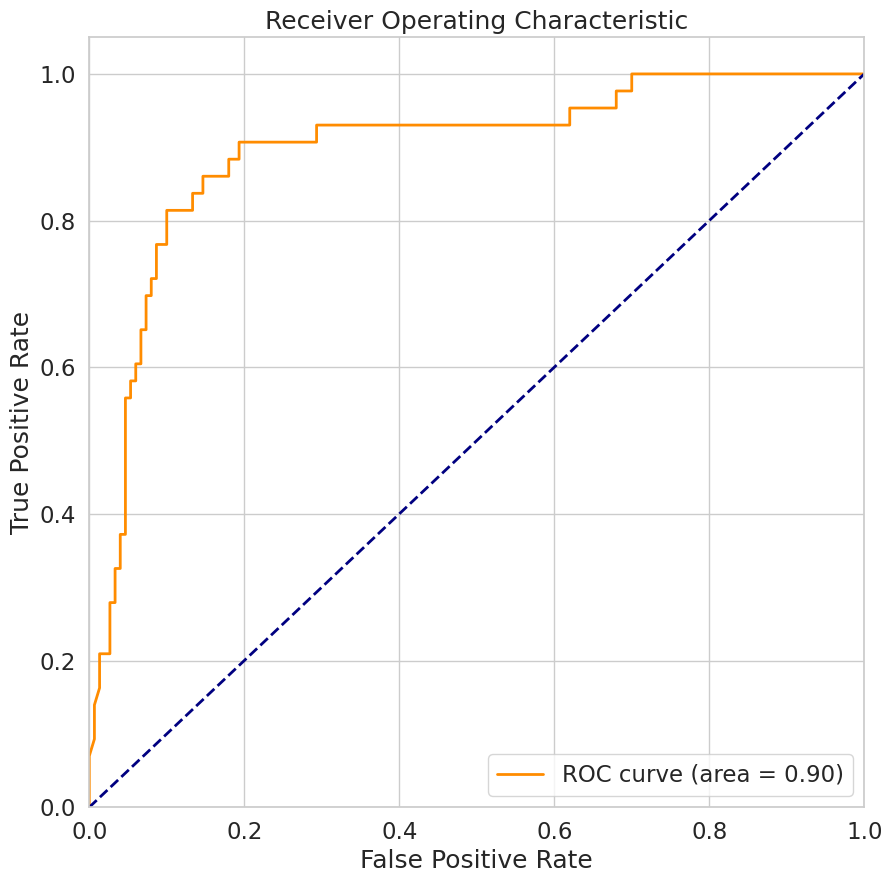

0.5 threshold 

Test accuracy: 88.60%
F1 score: 0.7027027027027027
Matthew Correlation Coefficient: 0.6359602470584612
Aucroc: 0.9339869281045751
Precision: 0.7647058823529411
Recall: 0.65


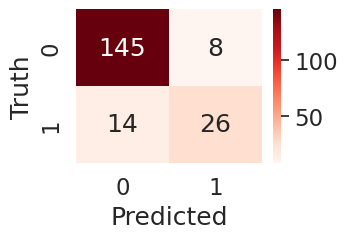

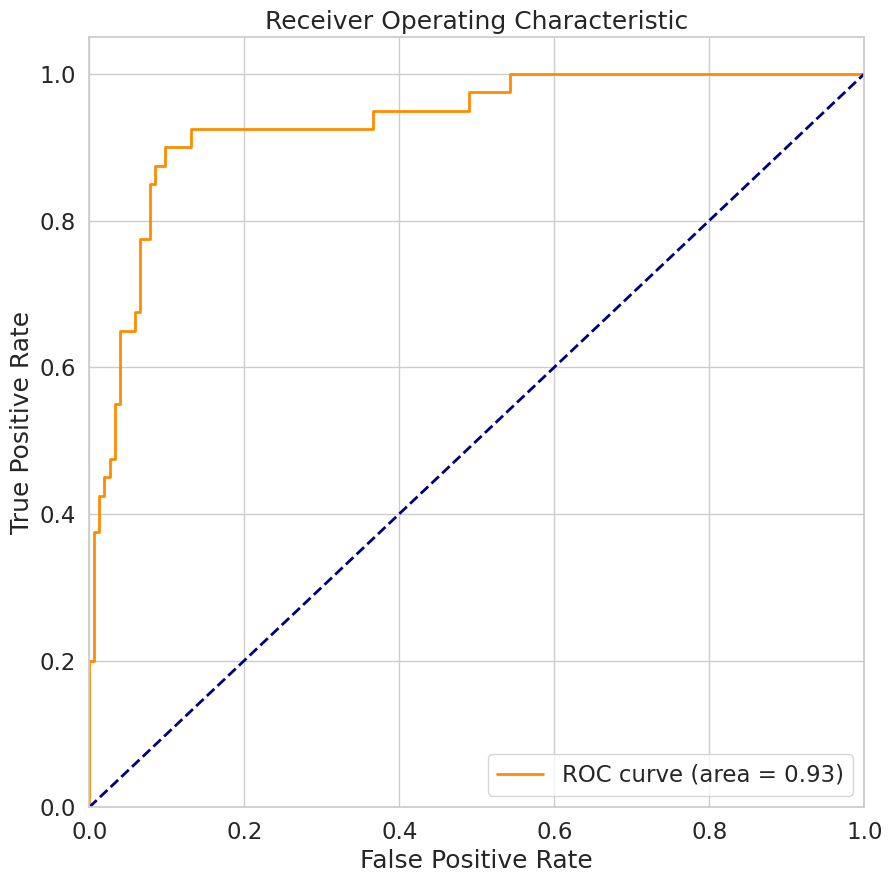

0.4 threshold 

Test accuracy: 89.64%
F1 score: 0.7619047619047619
Matthew Correlation Coefficient: 0.6971622794384399
Aucroc: 0.9339869281045751
Precision: 0.7272727272727273
Recall: 0.8


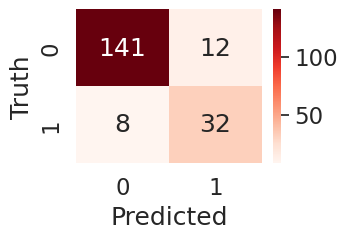

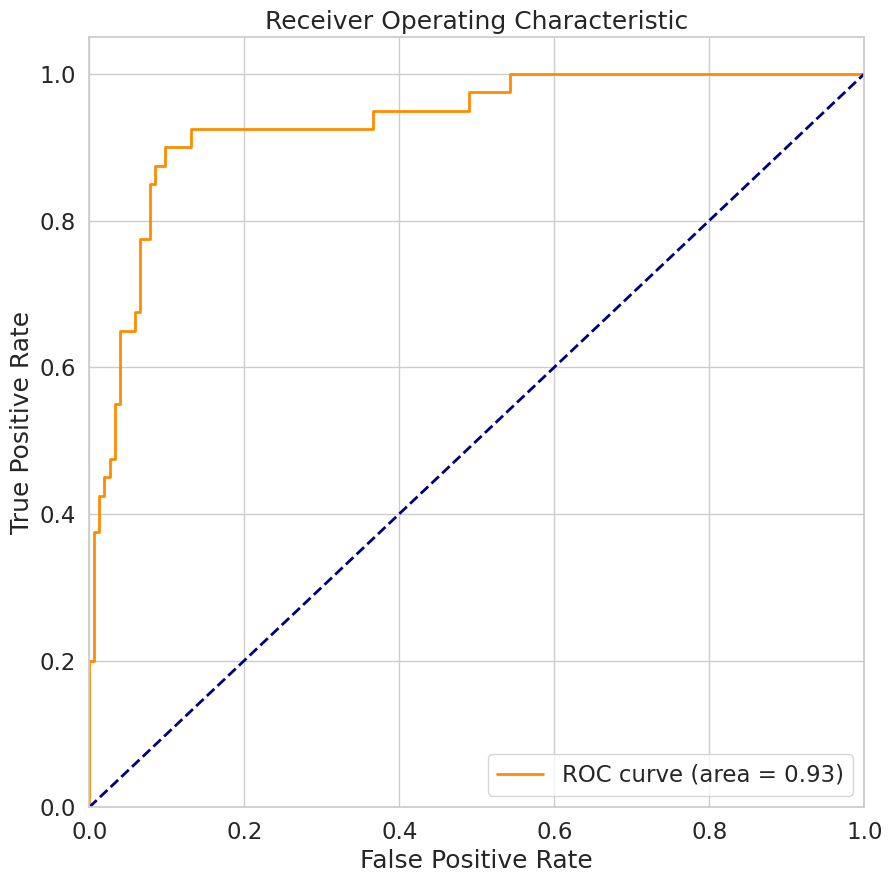

0.5 threshold 

Test accuracy: 91.71%
F1 score: 0.8048780487804879
Matthew Correlation Coefficient: 0.7526471177044042
Aucroc: 0.9651960784313726
Precision: 0.7857142857142857
Recall: 0.825


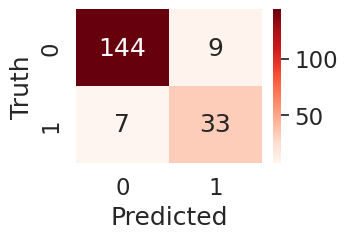

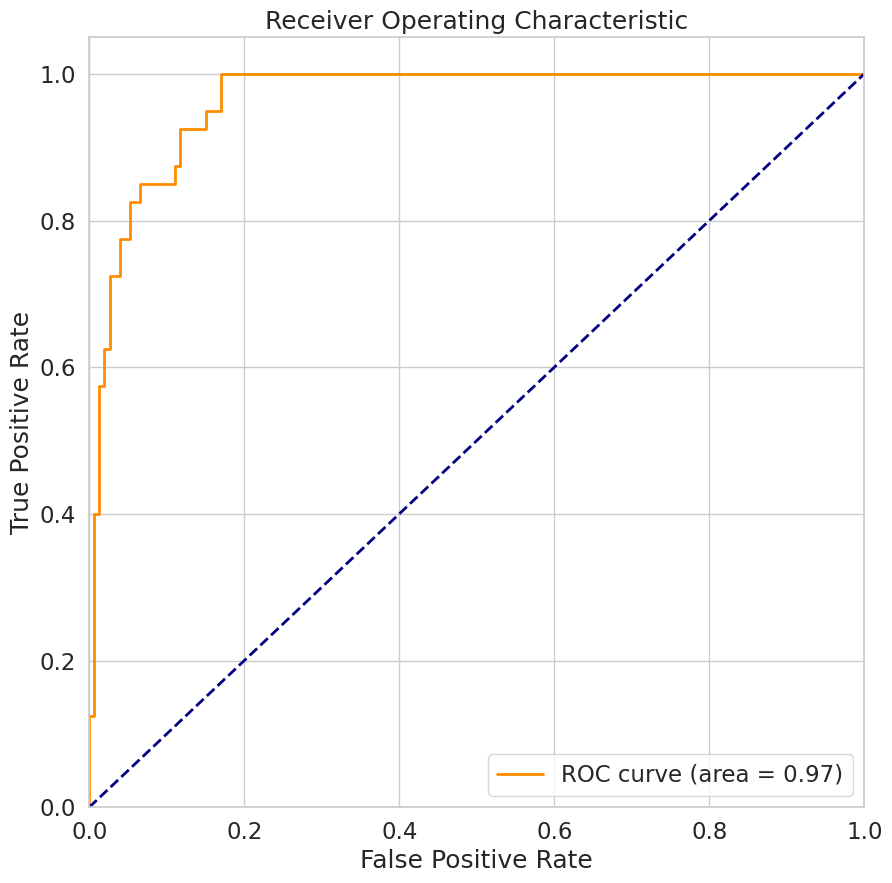

0.4 threshold 

Test accuracy: 91.19%
F1 score: 0.8
Matthew Correlation Coefficient: 0.7458930583493248
Aucroc: 0.9651960784313726
Precision: 0.7555555555555555
Recall: 0.85


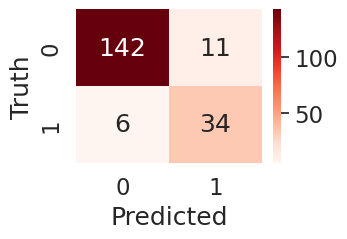

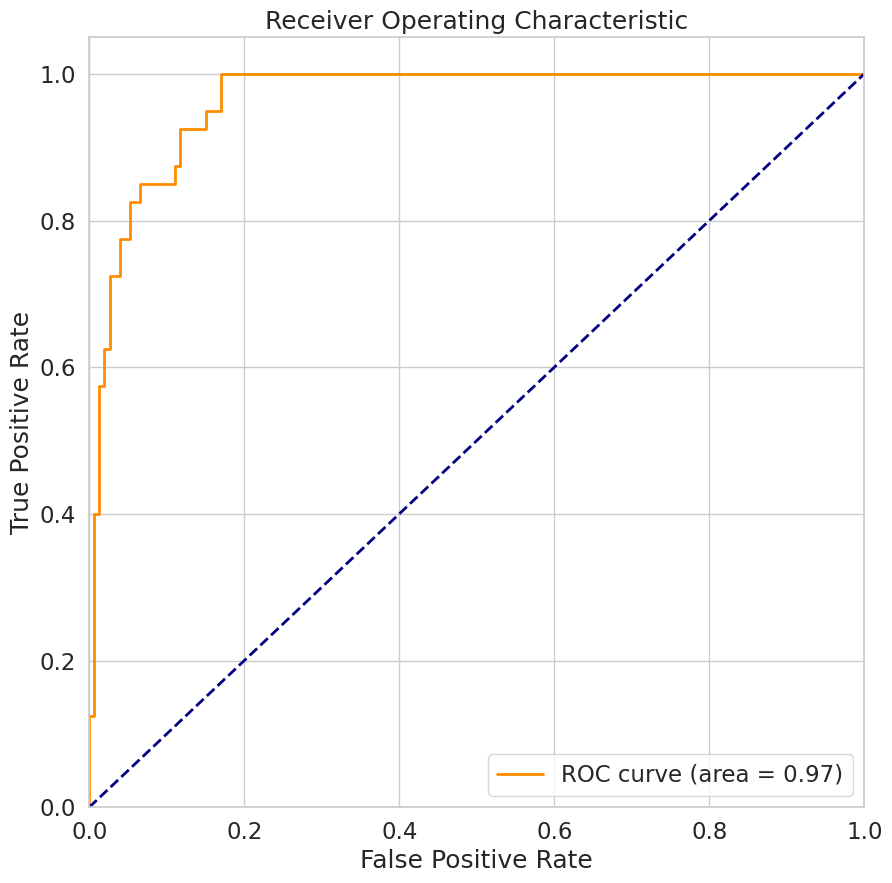

0.5 threshold 

Test accuracy: 88.60%
F1 score: 0.7027027027027027
Matthew Correlation Coefficient: 0.6338616001080669
Aucroc: 0.9075924075924074
Precision: 0.7428571428571429
Recall: 0.6666666666666666


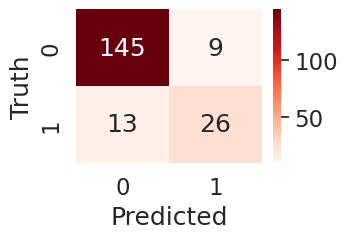

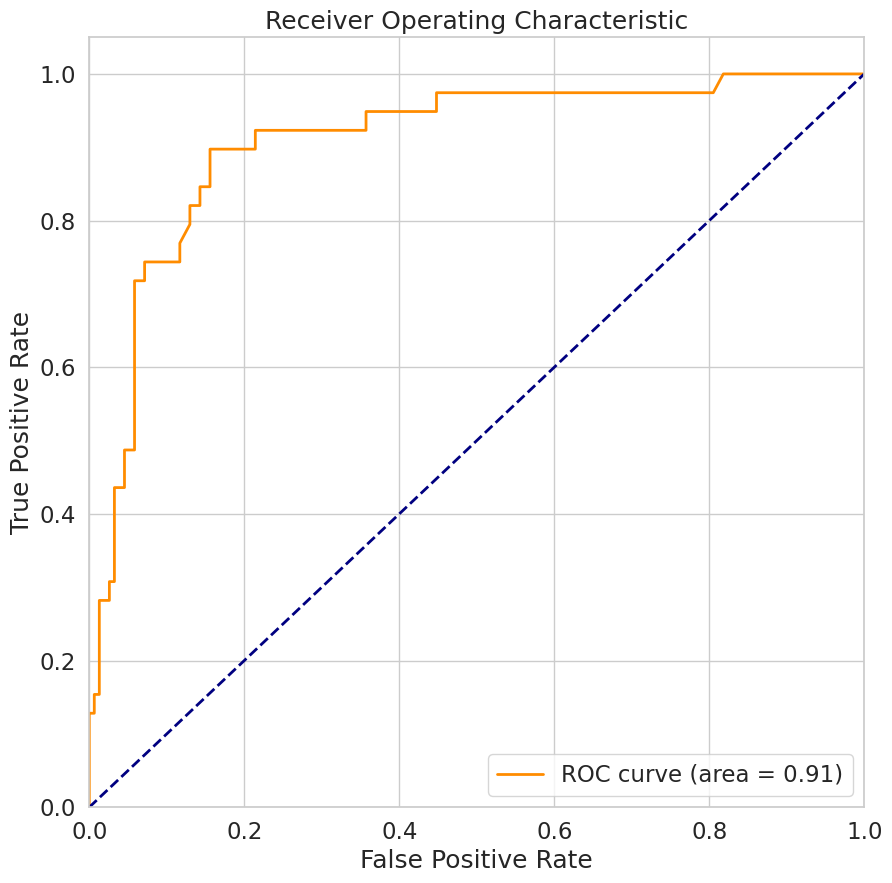

0.4 threshold 

Test accuracy: 89.12%
F1 score: 0.7341772151898734
Matthew Correlation Coefficient: 0.6658714193154844
Aucroc: 0.9075924075924074
Precision: 0.725
Recall: 0.7435897435897436


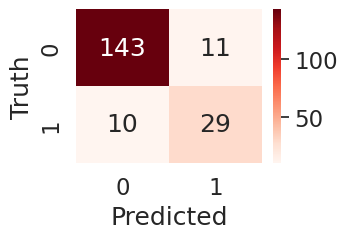

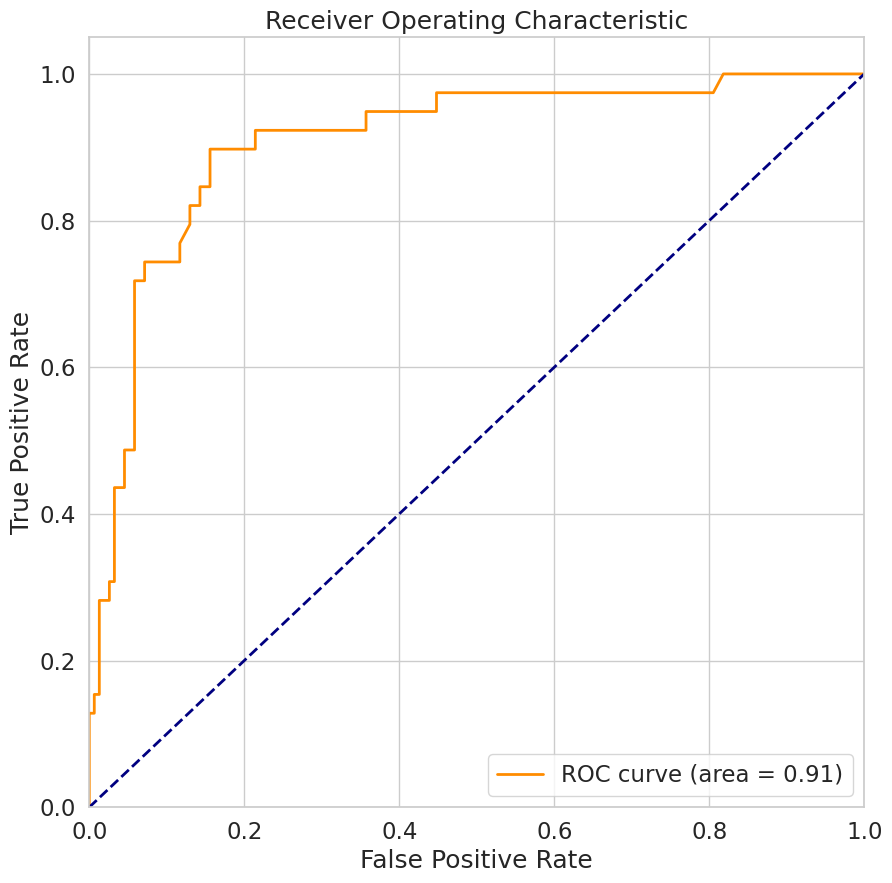

0.5 threshold 

Test accuracy: 89.12%
F1 score: 0.7692307692307693
Matthew Correlation Coefficient: 0.7001336572541969
Aucroc: 0.9399425287356322
Precision: 0.813953488372093
Recall: 0.7291666666666666


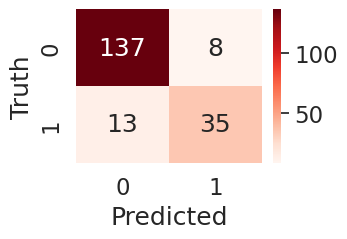

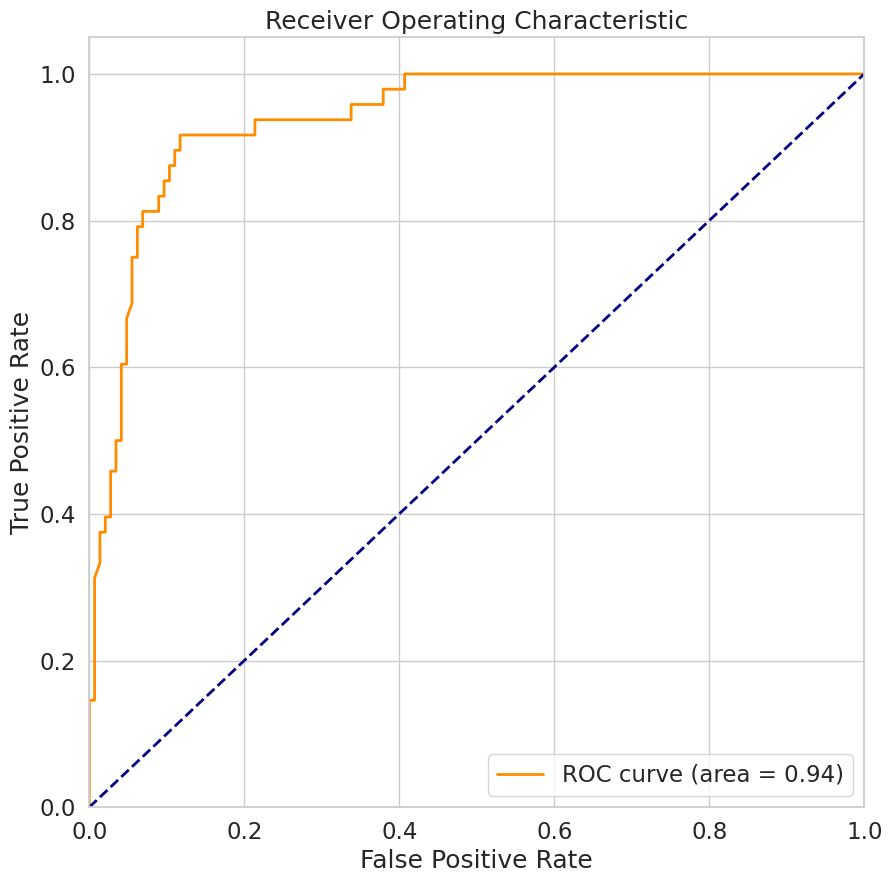

0.4 threshold 

Test accuracy: 89.12%
F1 score: 0.7741935483870968
Matthew Correlation Coefficient: 0.7032543178688051
Aucroc: 0.9399425287356322
Precision: 0.8
Recall: 0.75


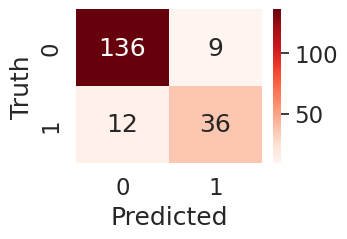

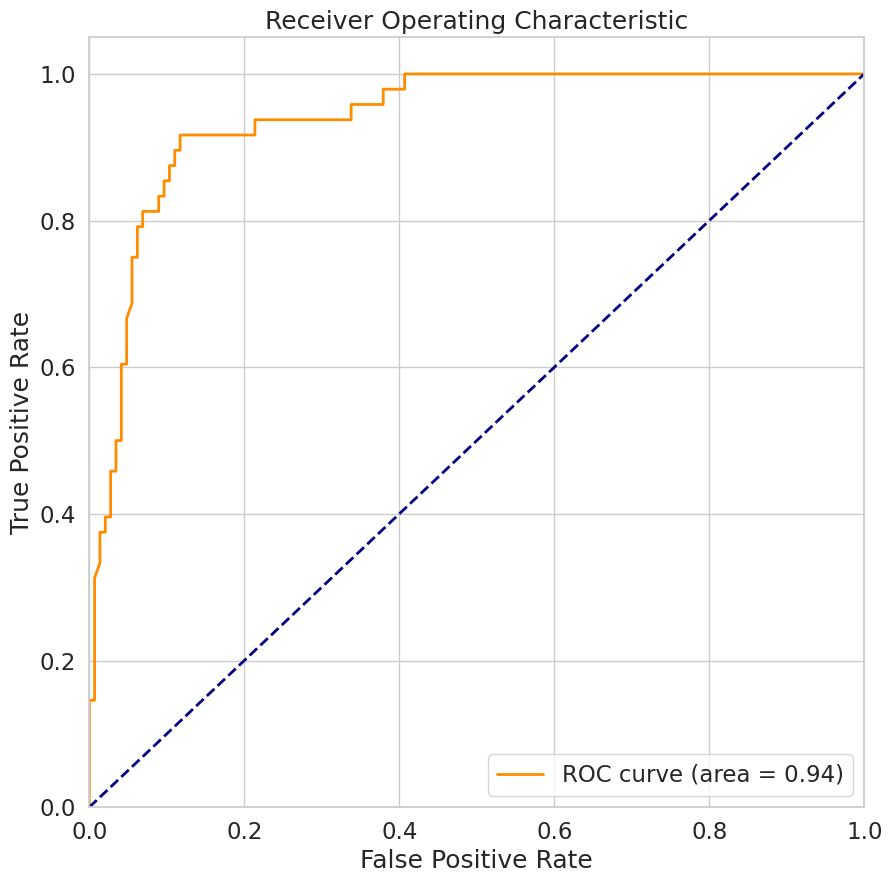

0.5 threshold 

Test accuracy: 87.56%
F1 score: 0.75
Matthew Correlation Coefficient: 0.6783103662295973
Aucroc: 0.9391153743671729
Precision: 0.8571428571428571
Recall: 0.6666666666666666


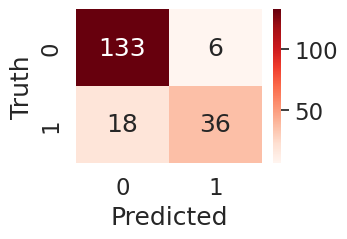

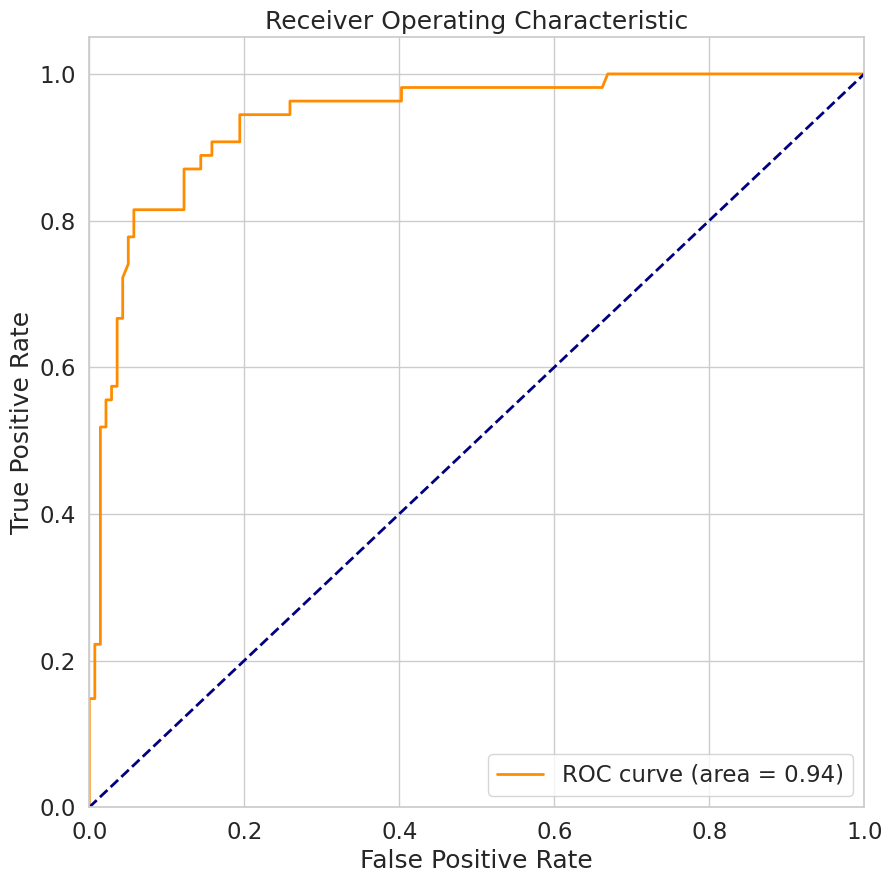

0.4 threshold 

Test accuracy: 88.60%
F1 score: 0.7755102040816326
Matthew Correlation Coefficient: 0.7067775886831862
Aucroc: 0.9391153743671729
Precision: 0.8636363636363636
Recall: 0.7037037037037037


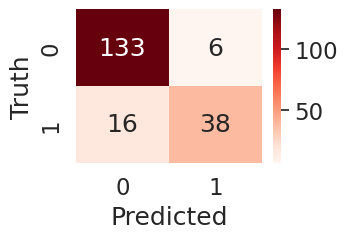

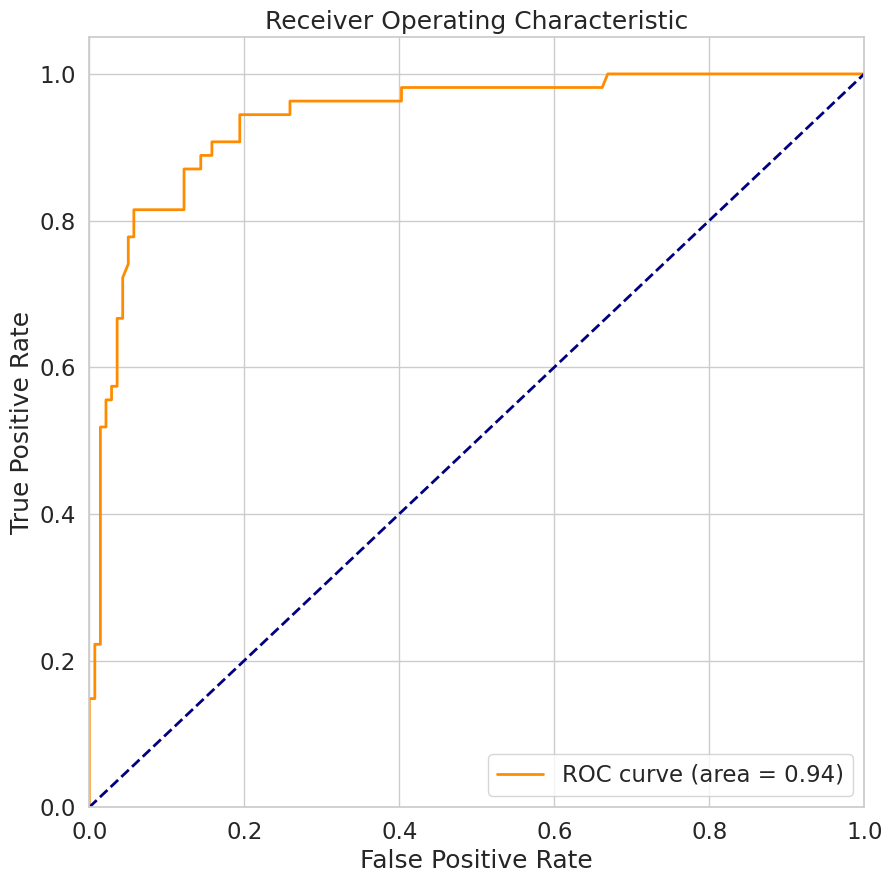

0.5 threshold 

Test accuracy: 88.60%
F1 score: 0.75
Matthew Correlation Coefficient: 0.6775459078876527
Aucroc: 0.9314096499526964
Precision: 0.717391304347826
Recall: 0.7857142857142857


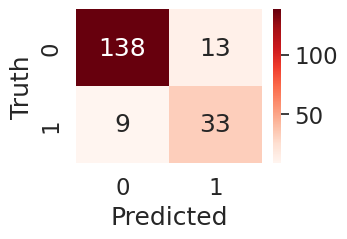

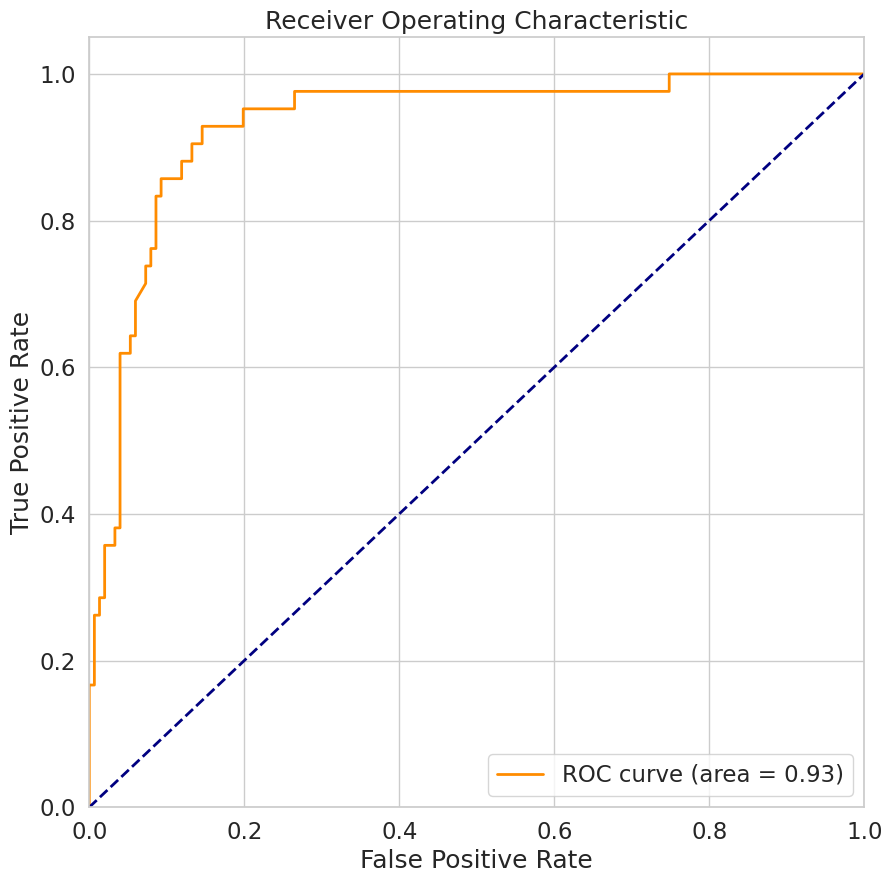

0.4 threshold 

Test accuracy: 89.12%
F1 score: 0.7741935483870968
Matthew Correlation Coefficient: 0.7091553561067813
Aucroc: 0.9314096499526964
Precision: 0.7058823529411765
Recall: 0.8571428571428571


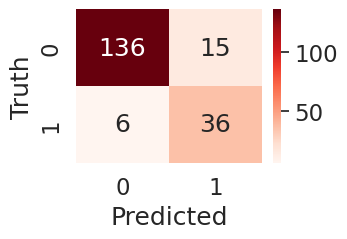

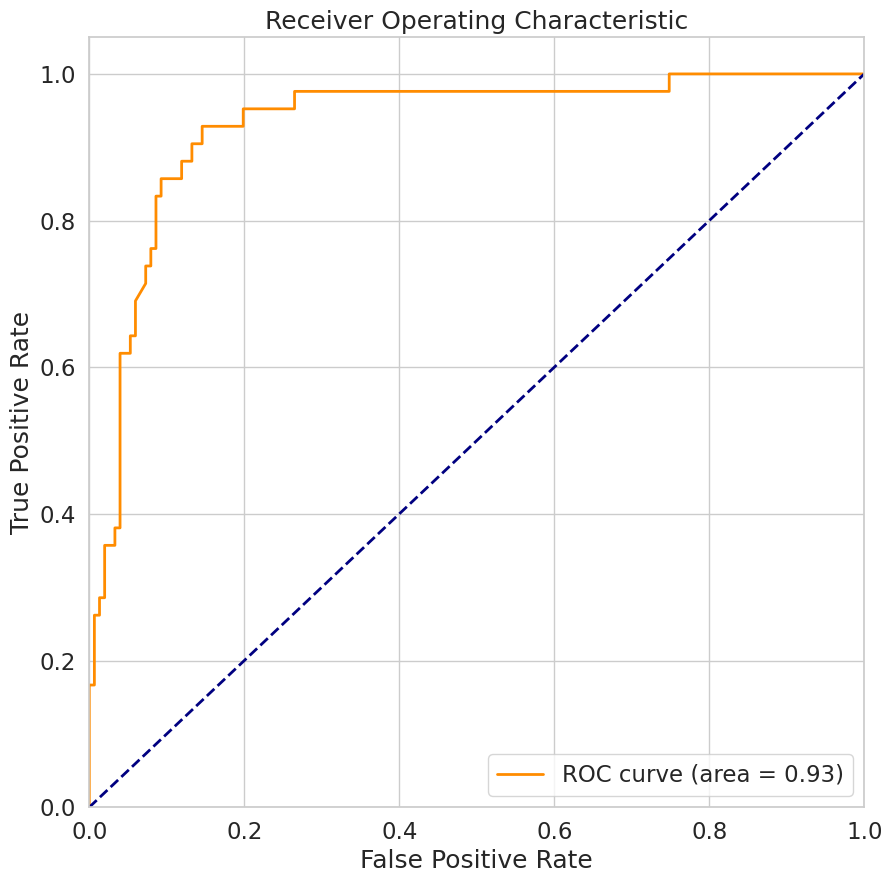

0.5 threshold 

Test accuracy: 84.97%
F1 score: 0.6881720430107527
Matthew Correlation Coefficient: 0.5892701309971325
Aucroc: 0.8982549541555752
Precision: 0.6808510638297872
Recall: 0.6956521739130435


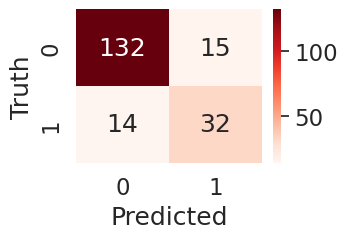

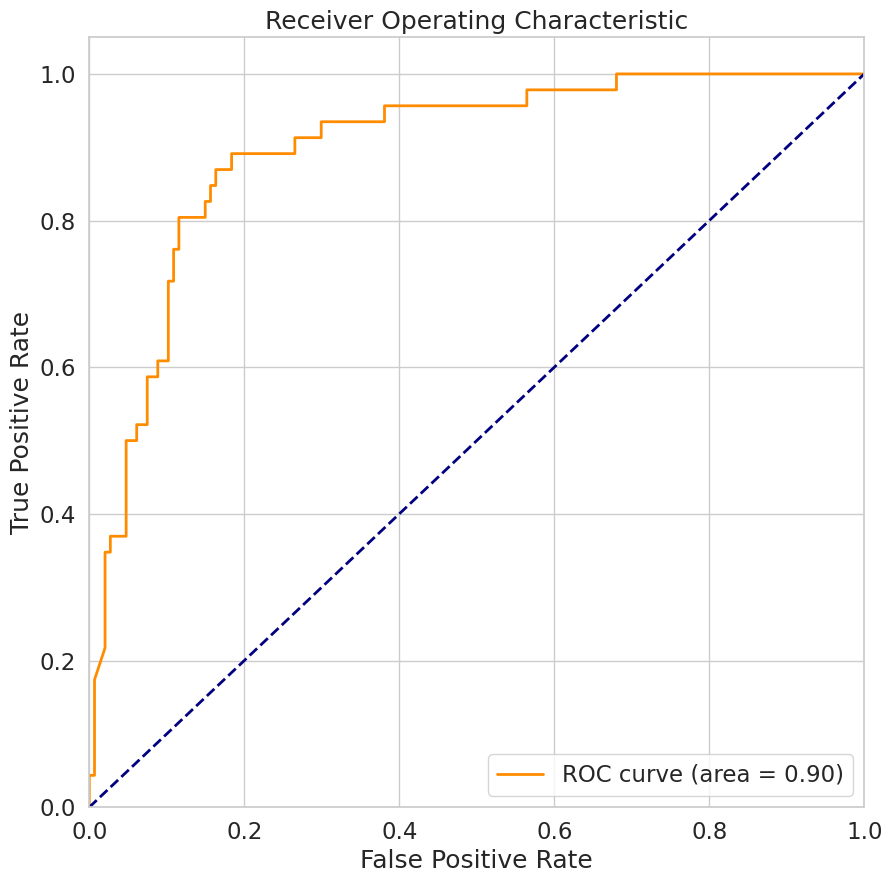

0.4 threshold 

Test accuracy: 85.49%
F1 score: 0.7083333333333334
Matthew Correlation Coefficient: 0.6129468835382768
Aucroc: 0.8982549541555752
Precision: 0.68
Recall: 0.7391304347826086


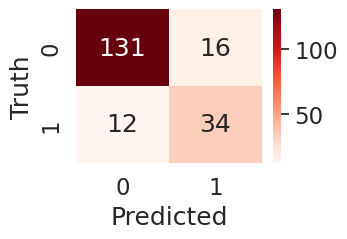

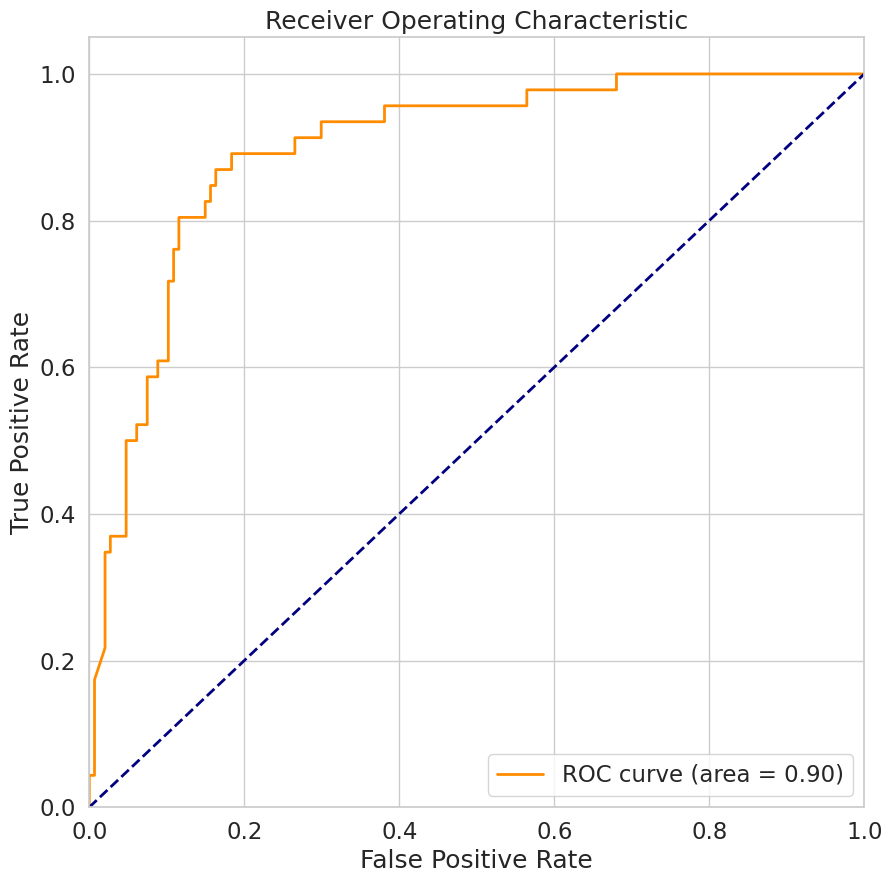

0.5 threshold 

Test accuracy: 88.08%
F1 score: 0.7012987012987013
Matthew Correlation Coefficient: 0.6277495018589365
Aucroc: 0.9304738562091504
Precision: 0.7297297297297297
Recall: 0.675


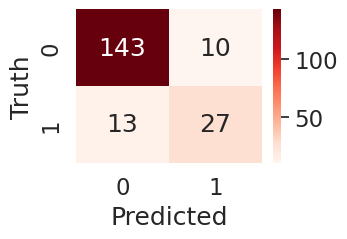

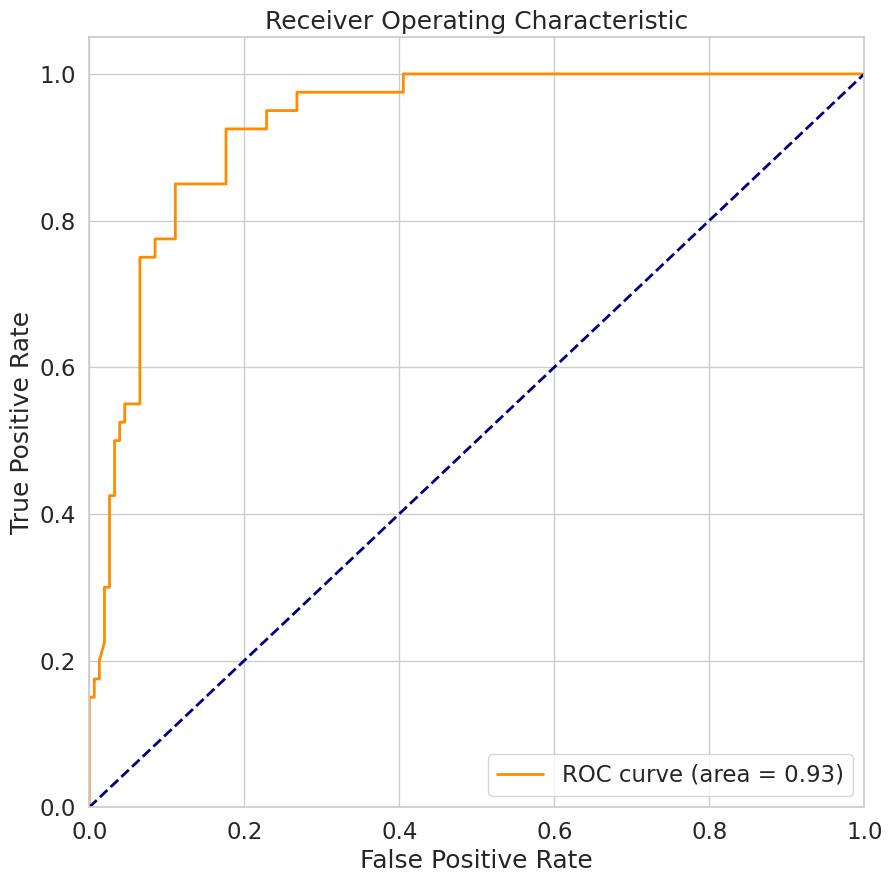

0.4 threshold 

Test accuracy: 88.60%
F1 score: 0.717948717948718
Matthew Correlation Coefficient: 0.6469129764702368
Aucroc: 0.9304738562091504
Precision: 0.7368421052631579
Recall: 0.7


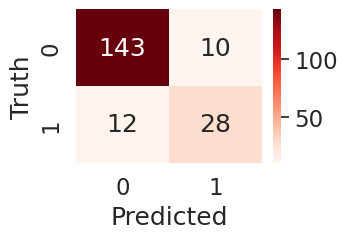

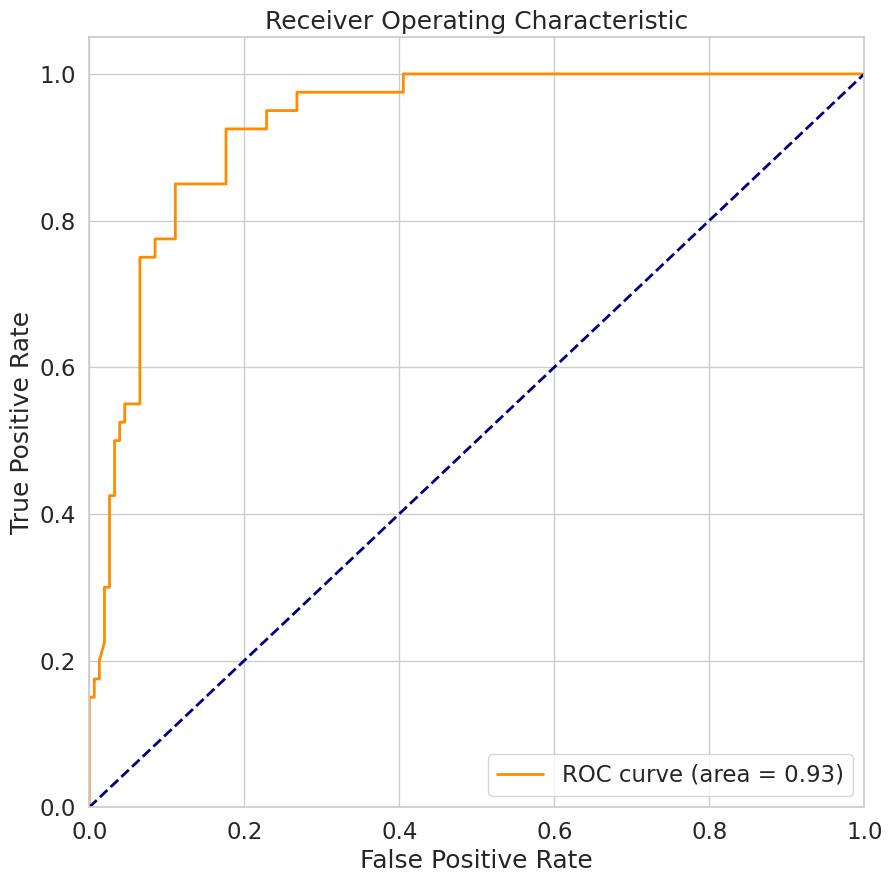

0.5 threshold 

Test accuracy: 90.67%
F1 score: 0.7857142857142857
Matthew Correlation Coefficient: 0.7322185682486592
Aucroc: 0.9387755102040817
Precision: 0.868421052631579
Recall: 0.717391304347826


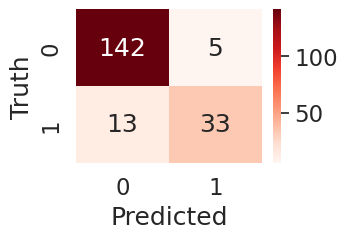

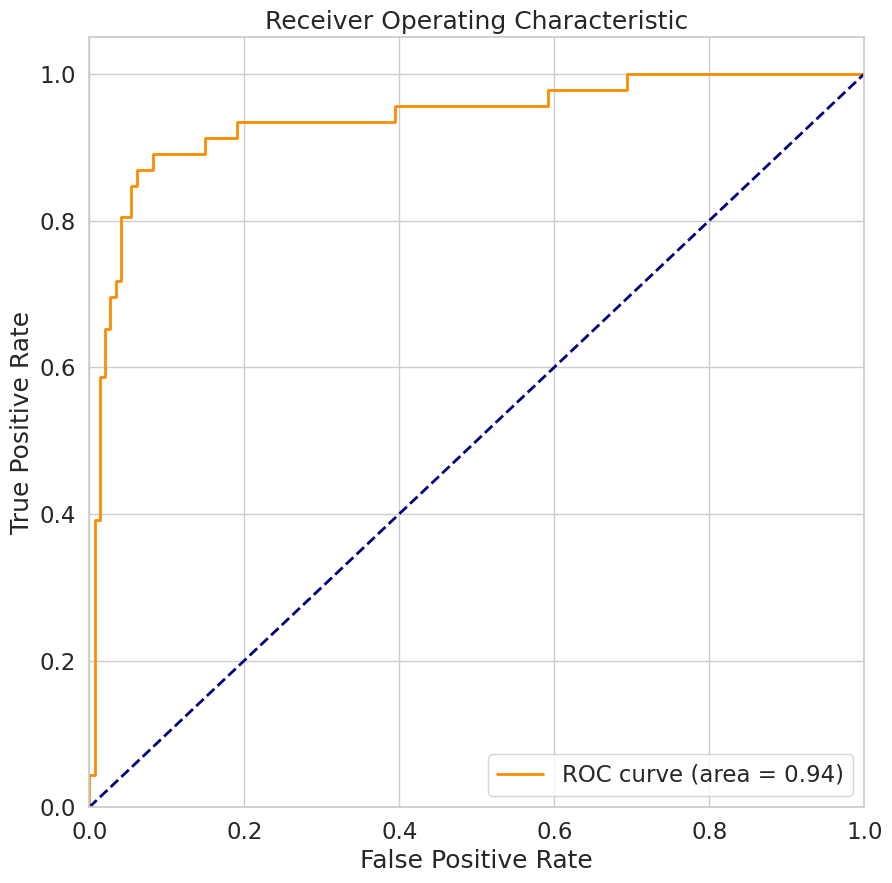

0.4 threshold 

Test accuracy: 91.71%
F1 score: 0.8222222222222222
Matthew Correlation Coefficient: 0.7685256400798094
Aucroc: 0.9387755102040817
Precision: 0.8409090909090909
Recall: 0.8043478260869565


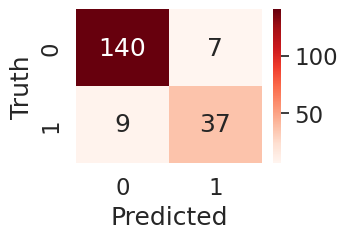

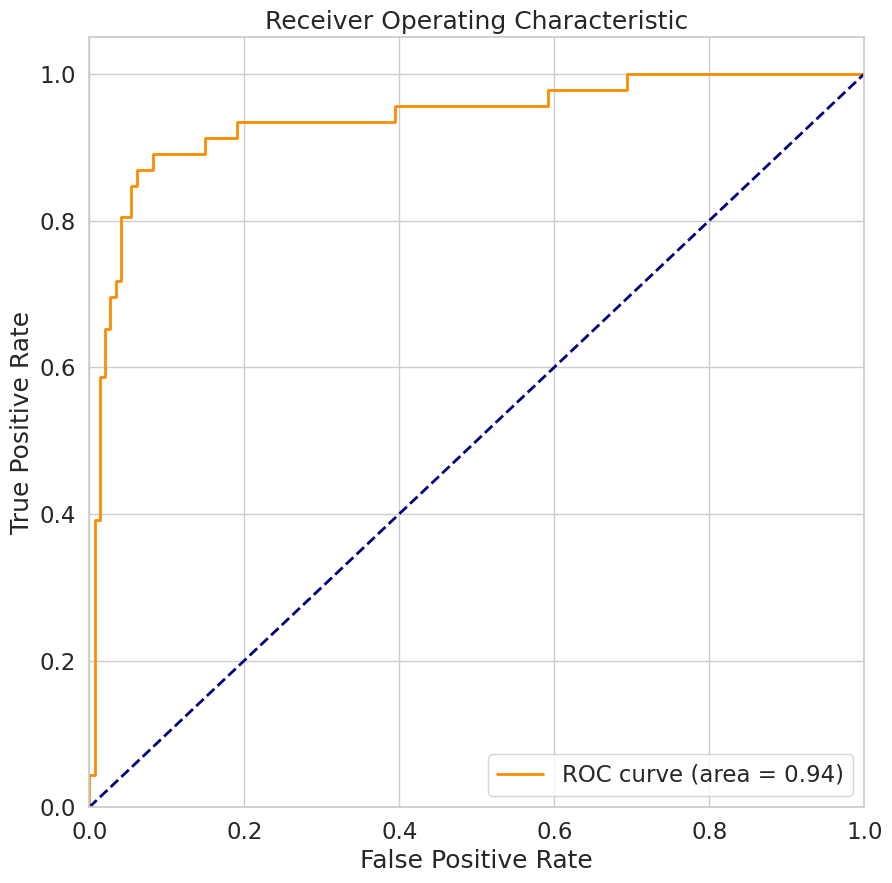

Cross-validated roc auc scores: [0.8965891472868217, 0.9339869281045751, 0.9651960784313726, 0.9075924075924074, 0.9399425287356322, 0.9391153743671729, 0.9314096499526964, 0.8982549541555752, 0.9304738562091504, 0.9387755102040817]
Mean roc auc score: 0.9281336435039484
Standard deviation of roc auc scores: 0.020266043123156975

Cross-validated f1 scores using 0.5 threshold: [0.7209302325581395, 0.7027027027027027, 0.8048780487804879, 0.7027027027027027, 0.7692307692307693, 0.75, 0.75, 0.6881720430107527, 0.7012987012987013, 0.7857142857142857]
Mean f1 score using 0.5 threshold: 0.7375629485998542
Standard deviation of f1 scores using 0.5 threshold: 0.038241029346740486

Cross-validated f1 scores using 0.4 threshold: [0.7446808510638298, 0.7619047619047619, 0.8, 0.7341772151898734, 0.7741935483870968, 0.7755102040816326, 0.7741935483870968, 0.7083333333333334, 0.717948717948718, 0.8222222222222222]
Mean f1 score using 0.4 threshold: 0.7613164402518564
Standard deviation of f1 scores u

In [ ]:
# Perform 5-fold cross-validation
cv = ShuffleSplit(n_splits=10)
auc_vals = []
f1_vals_50_thresh = []
f1_vals_40_thresh = []
for train_indices, valid_indices in cv.split(dataset_f_classif.X):
    # Split the dataset
    X_train, X_valid = dataset_f_classif.X[train_indices], dataset_f_classif.X[valid_indices]
    y_train, y_valid = dataset_f_classif.y[train_indices], dataset_f_classif.y[valid_indices]

    #print(f"\n X_train size: {X_train.shape}")
    #print(f"X_valid size: {X_valid.shape}")
    #print(f"y_train size: {y_train.shape}")
    #print(f"y_valid size: {y_valid.shape}")

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)


    param = {'objective': 'binary:logistic','booster': 'gbtree','lambda': 0.5502017520453772, 'alpha': 3.2707646459879734e-08, 'max_depth': 6, 'eta': 0.06482073900494274, 'gamma': 0.0006467974928444216, 'grow_policy': 'lossguide'}

    # Train the model
    model = xgb.train(param, dtrain, 70)

    # Validate the model
    y_pred = model.predict(dvalid)
    bin_y_pred_50_thresh= np.where(y_pred <= 0.5, 0, 1)
    bin_y_pred_40_thresh= np.where(y_pred <= 0.4, 0, 1)

    auc_val = roc_auc_score(y_valid, y_pred)
    auc_vals.append(auc_val)

    print("0.5 threshold \n")
    f1_val_50_thresh = model_metrics_calc(y_valid,bin_y_pred_50_thresh,y_pred)
    f1_vals_50_thresh.append(f1_val_50_thresh)

    print("0.4 threshold \n")
    f1_val_40_thresh = model_metrics_calc(y_valid,bin_y_pred_40_thresh,y_pred)
    f1_vals_40_thresh.append(f1_val_40_thresh)

# Report cross-validation scores
print(f"Cross-validated roc auc scores: {auc_vals}")
print(f"Mean roc auc score: {np.mean(auc_vals)}")
print(f"Standard deviation of roc auc scores: {np.std(auc_vals)}\n")

print(f"Cross-validated f1 scores using 0.5 threshold: {f1_vals_50_thresh}")
print(f"Mean f1 score using 0.5 threshold: {np.mean(f1_vals_50_thresh)}")
print(f"Standard deviation of f1 scores using 0.5 threshold: {np.std(f1_vals_50_thresh)}\n")

print(f"Cross-validated f1 scores using 0.4 threshold: {f1_vals_40_thresh}")
print(f"Mean f1 score using 0.4 threshold: {np.mean(f1_vals_40_thresh)}")
print(f"Standard deviation of f1 scores using 0.4 threshold: {np.std(f1_vals_40_thresh)}\n")


##Optimisation with optuna (add extra code to show how to store parameters)


In [ ]:
# Cross validation tune 2 (smaller ranges extra hyper parameters, f1 as scoring )

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'lambda': 1e-8,
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_float('eta', 1e-8, 0.2, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20)
    }


    model = xgb.XGBClassifier(**param,n_estimators = 70)

    # Return the mean cross-validation score
    return cross_val_score(model, train_dataset_f_c.X, train_dataset_f_c.y, cv=5, scoring='f1').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

[I 2025-06-23 18:29:12,959] A new study created in memory with name: no-name-e7bed316-e79b-4873-b433-57111b957557
[I 2025-06-23 18:29:15,224] Trial 0 finished with value: 0.0 and parameters: {'alpha': 0.04521011806999347, 'max_depth': 3, 'eta': 3.124980937976543e-06, 'grow_policy': 'lossguide', 'min_child_weight': 14}. Best is trial 0 with value: 0.0.


In [ ]:

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }


    model = xgb.XGBClassifier(**param)

    # Return the mean cross-validation score
    return cross_val_score(model, train_dataset_f_c.X, train_dataset_f_c.y, cv=5, scoring='roc_auc').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
# FINDING OPTIMAL PARAMETERS USING OPTUNA


def objective(trial):
    dtrain = xgb.DMatrix(train_dataset_f_c.X, label=train_dataset_f_c.y)
    dtest = xgb.DMatrix(valid_dataset_f_c.X, label=valid_dataset_f_c.y)

    param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_dataset_f_c.y, pred_labels)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(study.best_trial.params)


## SHAP

In [ ]:


# Initialize JavaScript visualization code for SHAP
shap.initjs()

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dataset_f_classif.X)

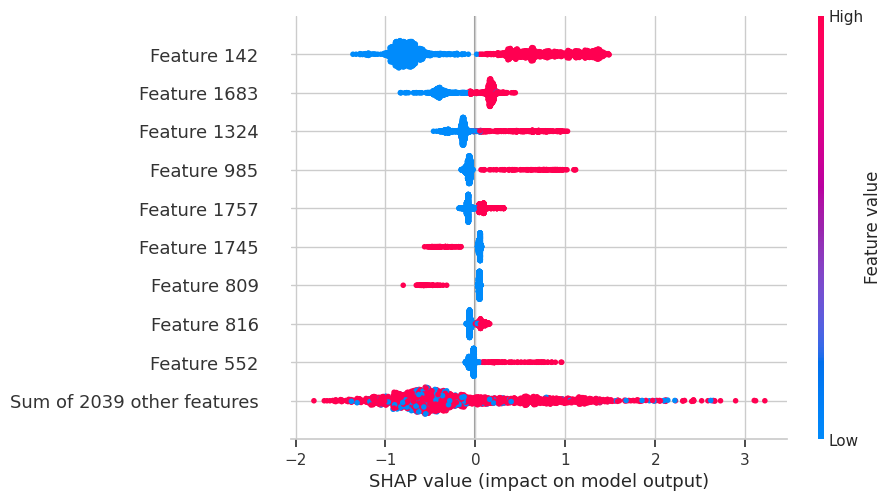

In [ ]:
explainer = shap.Explainer(model, dataset_f_classif.X)
shap_values = explainer(dataset_f_classif.X)

shap.plots.beeswarm(shap_values, max_display=10)

/tmp/ipython-input-76-1617849259.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, dataset_f_classif.X, plot_type="bar")


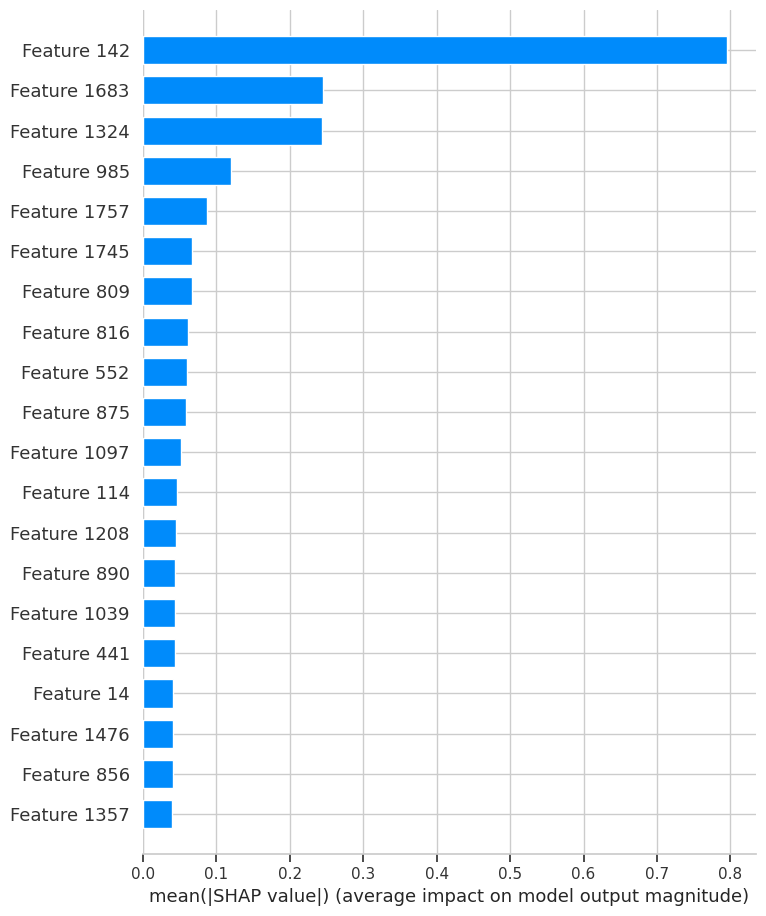

In [ ]:
shap.summary_plot(shap_values, dataset_f_classif.X, plot_type="bar")

# Fingerprint to image

##Inhibitor Class

In [ ]:
class Inhibitor:
  def __init__ (self, SMILES):
    self.SMILES = SMILES
    self.Mol = Chem.MolFromSmiles(self.SMILES)
    self.MorganFingerPrint, self.BitInfoMap = self._ComputeMorganFingerprintAndBitInfo(self.Mol)
    self.FingerprintArray = np.array(self.MorganFingerPrint.ToList())

  def _ComputeMorganFingerprintAndBitInfo(self, Mol):
    fpgen = AllChem.GetMorganGenerator(radius=2)
    ao = AllChem.AdditionalOutput()
    ao.CollectBitInfoMap()
    fp = fpgen.GetFingerprint(Mol,additionalOutput=ao)

    bi = ao.GetBitInfoMap()

    return fp , bi

  def highlight_morgan_bit(self,bitNum):
    """
    bitNum : bit number in morganfinger print that you want to see, if the bit number
    is inactive all the returned variable will equal None

    Returns hl_mol, substruture_svg and atom_index

    hl_mol : bit image of molecule with highlighted substructure from active fingerprint bit
    substructure_svg : sharper image of substructure
    atom_index : atom index used by fingerprint bit number
    """
    if bitNum in self.BitInfoMap:

      atom_index = self.BitInfoMap[bitNum][0][0]
      env = Chem.FindAtomEnvironmentOfRadiusN(self.Mol,2,atom_index)
      hl_mol = deepcopy(self.Mol)


      atoms=set()
      for bidx in env:
        atoms.add(self.Mol.GetBondWithIdx(bidx).GetBeginAtomIdx())
        atoms.add(self.Mol.GetBondWithIdx(bidx).GetEndAtomIdx())
      substruc =(Chem.MolFragmentToSmiles(self.Mol,atomsToUse=list(atoms),bondsToUse=env))

      print(f"{bitNum} -> {substruc}")

      patt = Chem.MolFromSmarts(substruc)
      hl_mol.GetSubstructMatch(patt)
      substructure_svg = Draw.DrawMorganBit(self.Mol, bitNum, self.BitInfoMap, useSVG=True)
    else:
      substructure_svg = None
      atom_index = None
      hl_mol = None


    self.SubstructureSVG = substructure_svg
    self.HighlightedMol = hl_mol

    return  atom_index

  def XGBoostPredict(self):

    # Using the dataset from the moonshot import

    data_f_Z = deepcopy(data_f)
    data_f_Z = data_f_Z.reset_index(drop=True)
    data_f_Z = pd.concat([data_f_Z["SMILES"],pd.Series(data_f_labels)],ignore_index=True, axis=1)
    data_f_Z.columns = ["SMILES", "Labels"]



    # SMILES string is already in dataset, removes string from dataset to give a true prediction

    fpgen = AllChem.GetMorganGenerator(radius=2)
    fps = [fpgen.GetSparseCountFingerprint(Chem.MolFromSmiles(x)) for x in data_f_Z["SMILES"]]

    search = fpgen.GetSparseCountFingerprint(Chem.MolFromSmiles(self.SMILES))
    tanimoto_similarities = [DataStructs.TanimotoSimilarity(search,x) for x in fps]

    print(sum(tanimoto_similarities))


    for ind, x in enumerate(tanimoto_similarities):
      if x>0.99:
        print(ind)
        print("SMILES is in dataset and will be removed from before model training. It has a value")
        print(data_f_Z.loc[ind])
        data_f_Z.drop(ind,inplace=True)





    # Method that uses exact smiles
    #if self.SMILES in list(data_f_Z["SMILES"]):
      #print("SMILES is in dataset and will be removed from before model training. It has a value")
      #print(data_f_Z[data_f_Z["SMILES"]==self.SMILES])
      #data_f_Z = data_f_Z[data_f_Z["SMILES"]!=self.SMILES]

    # Featurise
    featuriser_Z = dc.feat.CircularFingerprint()
    data_f_features_Z = featuriser_Z(data_f_Z["SMILES"])




    dtrain = xgb.DMatrix(data_f_features_Z, label=data_f_Z["Labels"])
    dtest = xgb.DMatrix( featuriser_Z(self.SMILES))

    param = {'objective': 'binary:logistic','booster': 'gbtree','lambda': 0.5502017520453772, 'alpha': 3.2707646459879734e-08, 'max_depth': 6, 'eta': 0.06482073900494274, 'gamma': 0.0006467974928444216, 'grow_policy': 'lossguide'}

    # train the model


    num_round = 70

    model = xgb.train(param, dtrain, num_round)

    self.model = model


    # make prediction

    prediction = model.predict(dtest)
    print(prediction)

    return (f"The prediction is {float(prediction)}")

  def SHAPAnalyse (self):

    # Initialize JavaScript visualization code for SHAP
    shap.initjs()

    # Explain the model's predictions using SHAP
    explainer = shap.TreeExplainer(self.model)
    shap_values = explainer.shap_values(dataset_f_classif.X)

    explainer = shap.Explainer(model, dataset_f_classif.X)
    shap_values = explainer(dataset_f_classif.X)

    return shap.plots.beeswarm(shap_values, max_display=10)

  def SubstrucInMol (self, substruc):

    patt = Chem.MolFromSmarts(substruc)
    main_mol = deepcopy(self.Mol)
    main_mol.GetSubstructMatch(patt)
    self.main_mol = main_mol

    return main_mol













# How many inhibitors contain the substructure?


In [ ]:
#for smile in data_f["SMILES"]

mol1 = Inhibitor("Clc1ccc2CCCC(C(=O)Nc3cncc4ccccc34)c2c1")
print(type(mol1))
mol1.SubstrucInMol("Clc1cccc(CC(=O)Nc2cncc3ccccc23)c1F")
print((mol1.main_mol == mol1.Mol))

#__main__.Inhibitor   <class '__main__.Inhibitor'>

<class '__main__.Inhibitor'>
False


##Using Inhibitor Class

In [ ]:


mol1 = Inhibitor("COc1ccc(cc1CC(=O)Nc2cncc3c2cccc3)Cl")
mol1.highlight_morgan_bit(1683)
mol1.highlight_morgan_bit(1757)
mol1.highlight_morgan_bit(142)
mol1.highlight_morgan_bit(856)
mol1.highlight_morgan_bit(816)
mol1.highlight_morgan_bit(1357)
mol1.highlight_morgan_bit(1464)

mol1.HighlightedMol
#mol1.SubstructureSVG
mol1.XGBoostPredict()
mol1.Mol

1683 -> cc(Cl)c
1757 -> cncc(c)c
142 -> ccncc
856 -> cc(c)C(C(N)=O)CN
816 -> cccc(Cl)c
1357 -> ccc(c(N)c)c(c)c
1464 -> cc(c)C(C(N)=O)CN


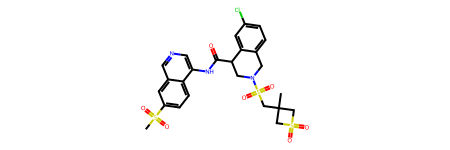

In [ ]:
mol1 = Inhibitor("CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4cc(S(C)(=O)=O)ccc34)C2)CS(=O)(=O)C1")
mol1.highlight_morgan_bit(1683)
mol1.highlight_morgan_bit(1757)
mol1.highlight_morgan_bit(142)
mol1.highlight_morgan_bit(856)
mol1.highlight_morgan_bit(816)
mol1.highlight_morgan_bit(1357)
mol1.highlight_morgan_bit(1464)

mol1.HighlightedMol
#mol1.SubstructureSVG
#mol1.XGBoostPredict()
mol1.Mol

In [ ]:
pdb860 = Inhibitor("Clc1cccc(CC(=O)Nc2cncc3ccccc23)c1")
pdb860.highlight_morgan_bit(816)
pdb860.highlight_morgan_bit(602)

pdb860.Mol
#pdb860.HighlightedMol
#pdb860.SubstructureSVG
pdb860.XGBoostPredict()
#pdb860.SHAPAnalyse()

In [ ]:


substructure = Inhibitor("Clc1ccc2CCCC(C(=O)Nc3cncc4ccccc34)c2c1")
substructure.highlight_morgan_bit(816)
substructure.highlight_morgan_bit(602)

substructure.Mol
#substructure.HighlightedMol
#substructure.SubstructureSVG
substructure.XGBoostPredict()
#substructure.SHAPAnalyse()


In [ ]:
# 379 from dataset, I later found that this is the exact structure of nirmatralvir

mol2 = Inhibitor("CC(C)(C)[C@H](NC(=O)C(F)(F)F)C(=O)N1C[C@H]2[C@@H]([C@H]1C(=O)N[C@H](C#N)C[C@@H]1CCNC1=O)C2(C)C")
mol2.highlight_morgan_bit(1683)
mol2.highlight_morgan_bit(1757)
mol2.highlight_morgan_bit(142)
mol2.highlight_morgan_bit(856)
mol2.highlight_morgan_bit(816)
mol2.highlight_morgan_bit(1357)


mol2.Mol
#mol2.SubstructureSVG
#mol2.XGBoostPredict()

In [ ]:
nirmatralvir = Inhibitor("N#C[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]1N(C[C@H]2[C@@H]1C2(C)C)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F")
nirmatralvir.highlight_morgan_bit(142)
nirmatralvir.highlight_morgan_bit(856)

nirmatralvir.Mol
#nirmatralvir.HighlightedMol
nirmatralvir.XGBoostPredict()

##old function method

In [ ]:
def bit_in_mol (bitNum, smiles):
  ''' Enter a morgan fingerprint bit number and smiles string and this function will return a SVG image of the section of the molecule if it contains the bit
  bitNum = chosen bit number to detect
  smiles = SMILES of molecule that is being analysed
  mol = whole molecule
  substructure_svg = SVG image of section that the bit corresponds to if the bit is in mol
  atom_index = contains the atom index that the bit corresponds to
  '''



  mol = Chem.MolFromSmiles(smiles)
  fpgen = AllChem.GetMorganGenerator(radius=2)

  ao = AllChem.AdditionalOutput()
  ao.CollectBitInfoMap()
  fp = fpgen.GetFingerprint(mol,additionalOutput=ao)

  bi = ao.GetBitInfoMap()

  if bitNum in bi:

    atom_index = bi[bitNum][0][0]
    print(bi)
    print(atom_index)

    env = Chem.FindAtomEnvironmentOfRadiusN(mol,2,atom_index)
    hl_mol = deepcopy(mol)


    atoms=set()
    for bidx in env:
        atoms.add(mol.GetBondWithIdx(bidx).GetBeginAtomIdx())
        atoms.add(mol.GetBondWithIdx(bidx).GetEndAtomIdx())
    substruc =(Chem.MolFragmentToSmiles(mol,atomsToUse=list(atoms),bondsToUse=env))

    patt = Chem.MolFromSmarts(substruc)
    hl_mol.GetSubstructMatch(patt)
    substructure_svg = Draw.DrawMorganBit(mol, bitNum, bi, useSVG=True)
  else:
    substructure_svg = None
    atom_index = None
    hl_mol = None



  return mol, substructure_svg, atom_index,hl_mol


In [ ]:
def highlight_morgan_bits_substructure(bitNum, smiles):

    df_with_bit_substructure = pd.DataFrame()
    for ind,smi in enumerate(smiles):
      mol, substructure_svg, atom_index, hl_mol = bit_in_mol(bitNum, smi)

      df_with_bit_substructure = pd.concat([df_with_bit_substructure,pd.Series({"SMILES":smi,"whole molecule": mol, "substructure svg":substructure_svg, "atom index": atom_index, "highlighted molecule":hl_mol})],axis=1,ignore_index=True)

    df_with_bit_substructure = df_with_bit_substructure.T


    return df_with_bit_substructure

##Interesting features(old dataframe method)


In [ ]:
df_with_bit_substructure_1757 = highlight_morgan_bits_substructure(1757,dataset_f_classif.ids)

In [ ]:
df_with_bit_substructure_856 = highlight_morgan_bits_substructure(856,dataset_f_classif.ids)

In [ ]:
df_with_bit_substructure_142 = highlight_morgan_bits_substructure(142,dataset_f_classif.ids)

In [ ]:
df_with_bit_substructure_602 = highlight_morgan_bits_substructure(602,dataset_f_classif.ids)

In [ ]:
df_with_bit_substructure_890 = highlight_morgan_bits_substructure(890,dataset_f_classif.ids)

In [ ]:
grid = pd.concat([df_with_bit_substructure['SMILES'], df_with_bit_substructure.iloc[:,4]], axis = 1, )
mols2grid.display( grid,subset=['img' ],tooltip=["SMILES"])

In [ ]:
print(df_with_bit_substructure_1757)

In [ ]:
df_with_bit_substructure_142["highlighted molecule"][191]

In [ ]:
df_with_bit_substructure_1757["highlighted molecule"][191]


In [ ]:
df_with_bit_substructure_856["highlighted molecule"][191]

In [ ]:
df_with_bit_substructure_602["highlighted molecule"][191]

In [ ]:
df_with_bit_substructure_890["highlighted molecule"][191]